## 리모델링이 주택 가격에 미치는 영향 분석

--------------

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import set_matplotlib_hangul
import warnings
import scipy.stats as stats
import shap
import joblib
import statsmodels.api as sm 
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import mannwhitneyu, shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import het_breuschpagan

Hangul OK in your MAC!


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

# load Data
df = pd.read_csv("../data/feature_important.csv", index_col=0)
df

,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,GarageType,MSSubClass,Foundation,FireplaceQu,HeatingQC,...,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,WoodDeckSF,MoSold,YrSold,SalePrice
0,CollgCr,Gd,Gd,Gd,RFn,Attchd,60,PConc,No_FireplaceQu,Ex,...,8,2003,2003,196.0,0,706,0,2,2008,208500
1,Veenker,TA,Gd,TA,RFn,Attchd,20,CBlock,TA,Ex,...,6,1976,1976,0.0,1,978,298,5,2007,181500
2,CollgCr,Gd,Gd,Gd,RFn,Attchd,60,PConc,TA,Ex,...,6,2001,2002,162.0,1,486,0,9,2008,223500
3,Crawfor,TA,TA,Gd,Unf,Detchd,70,BrkTil,Gd,Gd,...,7,1915,1970,0.0,1,216,0,2,2006,140000
4,NoRidge,Gd,Gd,Gd,RFn,Attchd,60,PConc,TA,Ex,...,9,2000,2000,350.0,1,655,192,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Gilbert,TA,Gd,TA,RFn,Attchd,60,PConc,TA,Ex,...,7,1999,2000,0.0,1,0,0,8,2007,175000
1456,NWAmes,TA,Gd,TA,Unf,Attchd,20,CBlock,TA,TA,...,7,1978,1988,119.0,2,790,349,2,2010,210000
1457,Crawfor,Ex,TA,Gd,RFn,Attchd,70,Stone,Gd,Ex,...,9,1941,2006,0.0,2,275,0,5,2010,266500
1458,NAmes,TA,TA,Gd,Unf,Attchd,20,CBlock,No_FireplaceQu,Gd,...,5,1950,1996,0.0,0,49,366,4,2010,142125


In [3]:
def data_type_check(df):
    objects = df.select_dtypes(include=['object']).columns
    num = df.select_dtypes(include=['number']).columns

    print(f"Str dtypes: {len(objects)}개")
    print(f"Num dtypes: {len(num)}개")

data_type_check(df) # 확인

Str dtypes: 36개
Num dtypes: 16개


In [4]:
# 재확인
df['MSSubClass'].dtype

dtype('int64')

In [5]:
# 지난 EDA 결과에서 'MSSubClass'를 범주형으로 변환했으나 read_csv 하면서 수치형으로 전환됨 그래서 재 변환
df['MSSubClass'] = df['MSSubClass'].astype(str)

data_type_check(df)

Str dtypes: 37개
Num dtypes: 15개


## 1.&nbsp; 리모델링 효과 분석

- **목적**: 리모델링 여부가 **SalePrice에** 유의미한 영향을 미치는지 검증

- **선정 기준**:  리모델링 여부를 판단하기 위해 리모델링 연도가 건축 연도와 동일한 경우 리모델링을 하지 않았다고 간주
- ```if YearRemodAdd = YearBuilt → Not Remodeled (0)```

In [6]:
# 선정 기준에 맞게 라벨링
df['Remodel_Label'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int) # True는 1로, False는 0으로 변환

# 라벨 조회
df_Remodel = df[df['Remodel_Label'] == 1].copy() # 리모델링 데이터
df_Not_Remodel = df[df['Remodel_Label'] == 0].copy() # 리모델링을 하지 않은 데이터

print(f"Remodel Data length: {df_Remodel.shape[0]}")
print(f"Not Remodel Data length: {df_Not_Remodel.shape[0]}")

Remodel Data length: 696
Not Remodel Data length: 764


### 1-1. Class imbalance 확인

- 두 그룹 데이터 분포 결과 아래와 같음
- **Remodeled** (리모델링한 경우): 696개  
- **Not Remodeled** (리모델링하지 않은 경우): 764개  
- 따라서 **Class imbalance**이 존재하지 않아, 비교 분석을 수행하기에 적절한 데이터 구조를 갖추고 있음을 확인

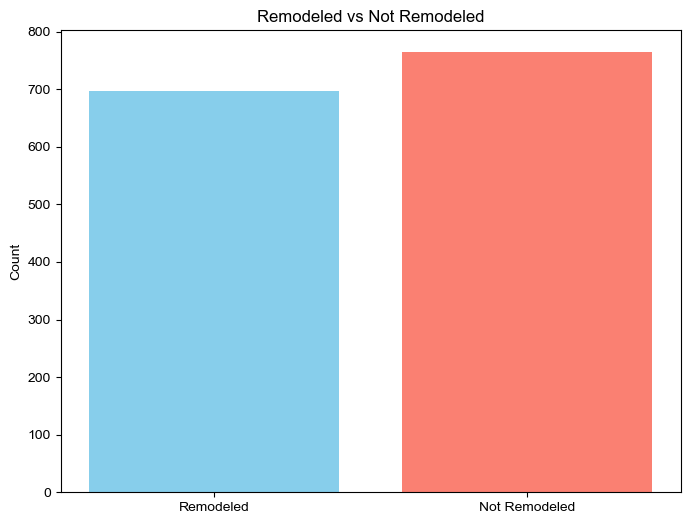

리모델링 그룹: 47.67%
비 리모델링 그룹: 52.33%


In [7]:
Remodel_cnt = len(df_Remodel)
Not_Remodel_cnt = len(df_Not_Remodel)

# 시각화
plt.figure(figsize=(8, 6))
plt.bar(['Remodeled', 'Not Remodeled'], [Remodel_cnt, Not_Remodel_cnt], color=['skyblue', 'salmon'])
plt.title('Remodeled vs Not Remodeled')
plt.ylabel('Count')
plt.show()

print(f"리모델링 그룹: {(Remodel_cnt / len(df) * 100):.2f}%")
print(f"비 리모델링 그룹: {(Not_Remodel_cnt / len(df) * 100):.2f}%")

### 1-2. 리모델링 여부에 따른 SalePrice 시각화

- 목적: 리모델링 여부에 따라 판매 가격(SalePrice)의 분포와 차이를 직관적으로 확인하기 위함.
- 설명: 두 그룹 간의 가격 분포 특성을 시각화하여 데이터 분포의 패턴과 **이상치(Outlier)** 를 파악

In [8]:
# 각 시각화 Class
class Visualizer:

    # 1. 박스플롯 (Boxplot)
    @staticmethod
    def plot_boxplot(df, x_col, y_col, figsize=(8, 6), palette=None, rotation=None, title=None):
        plt.figure(figsize=(figsize))
        sns.boxplot(x=df[x_col], y=df[y_col], palette=palette)
        plt.xticks(rotation=rotation)
        plt.title(title)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.show()

    # 2. 바이올린 플롯 (Violin Plot)
    @staticmethod
    def plot_violinplot(df, x_col, y_col, figsize=(8, 6), palette=None, rotation=None, title=None):
        plt.figure(figsize=figsize)
        sns.violinplot(x=df[x_col], y=df[y_col], palette=palette)
        plt.xticks(rotation=rotation)
        plt.title(title)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.show()

    # 3. 바 플롯 (bar_plot)
    @staticmethod
    def plot_barplot(df, x_col, y_col, figsize=(12, 6), palette=None, rotation=None, title=None):
        plt.figure(figsize=figsize)
        sns.barplot(x=df[x_col], y=df[y_col], data=df, palette=palette)
        plt.xticks(rotation=rotation)
        plt.title(title)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.show()

    # 4. 히스토그램 (Histogram + KDE)
    @staticmethod
    def plot_histplot(df1, df2, col, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None):
        plt.figure(figsize=figsize)
        sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1) # 그룹 1
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2) # 그룹 2
        plt.title(f'{col} Distribution (Histogram + KDE)')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    # 5. 라인 플롯 (Line Plot)
    @staticmethod
    def plot_lineplot(df, x_col, y_col, figsize=(12, 6), color=None, marker='o', linewidth=2, rotation=None, title=None):
        plt.figure(figsize=figsize)
        sns.lineplot(x=df[x_col], y=df[y_col], data=df, color=color, marker=marker, linewidth=linewidth)
        plt.xticks(rotation=rotation)  
        plt.title(title if title else f'{y_col} by {x_col} (Line Plot)')  
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True)
        plt.show()    

    # A/B Test: 두 그룹 비교 시각화 
    @staticmethod
    def plot_all(df, x_col, y_col, figsize=(16, 12), palette=['skyblue', 'salmon']):
        plt.figure(figsize=figsize)

        plt.subplot(2, 2, 1)
        sns.boxplot(x=df[x_col], y=df[y_col], palette=palette)
        plt.title(f'{y_col} by {x_col} (Boxplot)')
        plt.xlabel(x_col)
        plt.ylabel(y_col)

        plt.subplot(2, 2, 2)
        sns.violinplot(x=df[x_col], y=df[y_col], palette=palette)
        plt.title(f'{y_col} by {x_col} (Violin Plot)')
        plt.xlabel(x_col)
        plt.ylabel(y_col)

        plt.subplot(2, 2, 3)
        sns.histplot(df[df[x_col] == 0][y_col], label='Group 0', color='skyblue', kde=True, stat='density', alpha=0.6)
        sns.histplot(df[df[x_col] == 1][y_col], label='Group 1', color='salmon', kde=True, stat='density', alpha=0.6)
        plt.title(f'{y_col} Distribution by {x_col} (Histogram + KDE)')
        plt.xlabel(y_col)
        plt.ylabel('Density')
        plt.legend()

        plt.subplot(2, 2, 4)
        sns.stripplot(x=x_col, y=y_col, data=df, palette=palette, jitter=0.3, size=4)
        plt.title(f'{y_col} by {x_col} (Strip Plot)')
        plt.xlabel(x_col)
        plt.ylabel(y_col)

        plt.tight_layout()
        plt.show()

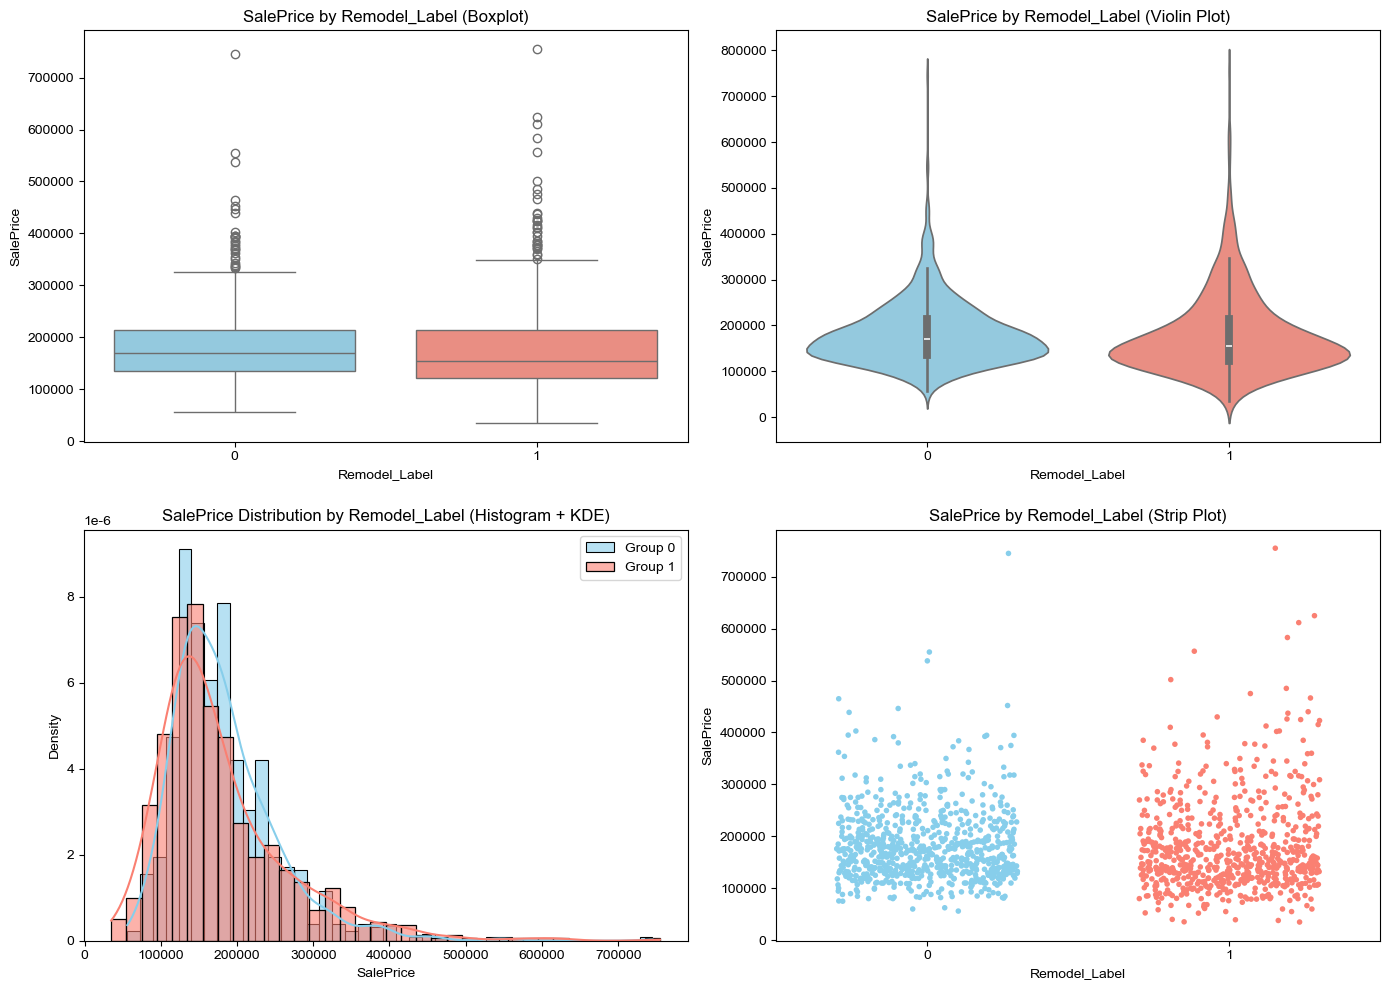

In [9]:
# Class 호출: 리모델링 여부에 따른 판매 가격 비교
Visualizer.plot_all(df, 'Remodel_Label', 'SalePrice', figsize=(14, 10))

### 1-3. Mann-Whitney U Test

- 위 시각화 결과 특히 **고가 주택에서** 리모델링 효과가 더 두드러진다 라고 해석할 수 있다.  
- **가격 변동성과 이상치가 존재**하므로 추가적인 통계적 검증 필요
- 또한 이전 EDA 결과에서 'SalePrice' 분포는 정규 분포를 따르지 않는 것으로 확인됨, 하지만 혹시 모르니 개별 정규성 검정.
- 이에 따라 두 그룹 간 판매 가격 차이를 검증하기 위해 비교 시각화와 **비모수 검정**인 **Mann-Whitney U Test**를 적용. 

In [10]:
# Shapiro_Test 함수  
def shapiro_test(df, name):
    stat, p_value = shapiro(df)
        
    if p_value > 0.05:
        print(f"귀무가설 기각 불가: {name}은 정규 분포를 따른다. (p-value: {p_value:.4e})")
    else:
        print(f"귀무가설 기각: {name}은 정규 분포를 따르지 않는다. (p-value: {p_value:.4e})")
    

# U Test 함수
def u_test(group1, group2, alternative='two-sided'):

    u_stat, p_value = mannwhitneyu(group1, group2, alternative=alternative)

    if p_value > 0.05:
        print(f"귀무가설을 기각 불가: 유의미한 차이가 없다. (p-value: {p_value:.4f})\t (U-statistic: {u_stat})")
    else:
        print(f"귀무가설 기각: 유의미한 차이가 있다. (p-value: {p_value:.4f})\t (U-statistic: {u_stat})")

    return u_stat, p_value

In [11]:
Remodel_prices = df_Remodel['SalePrice']
Not_Remodel_prices = df_Not_Remodel['SalePrice']

shapiro_test(Remodel_prices, '리모델링 그룹')
shapiro_test(Not_Remodel_prices, '비 리모델링 그룹')

귀무가설 기각: 리모델링 그룹은 정규 분포를 따르지 않는다. (p-value: 2.7674e-24)
귀무가설 기각: 비 리모델링 그룹은 정규 분포를 따르지 않는다. (p-value: 3.3487e-24)


In [12]:
u_stat, p_value = u_test(Remodel_prices, Not_Remodel_prices)

귀무가설 기각: 유의미한 차이가 있다. (p-value: 0.0011)	 (U-statistic: 239585.0)


### 1-4. 효과 크기(Effect Size)

- U Test 결과 유의미한 차이가 나타났지만, 그 차이가 실제로 얼마나 중요한지 확인하기 위해 계산
- 이는 표본 크기와 무관하게 차이의 실질적 영향력을 평가하고, p-value만으로는 알 수 없는 객관적 해석을 제공
- 리모델링이 판매 가격에 중요한 영향을 미치는지를 정량적으로 판단할 수 있음 또한 이 결과를 통해

- 효과 크기 분석 결과를 통해, 단순한 차이 존재 여부를 넘어 리모델링이 판매가격을 상승시킬 가능성을 발견
- 따라서, 리모델링 그룹이 비 리모델링 그룹보다 판매가격이 더 높다는 가설을 검증하기 위해 방향성 있는 U검정(‘greater’)을 진행

In [13]:
# 효과 크기 계산 (r-value)

n1, n2 = len(Remodel_prices), len(Not_Remodel_prices) 
r = u_stat / (n1 * n2)
print(f"Effect Size (r): {r:.4f}")

Effect Size (r): 0.4506


In [14]:
# 효과 크기 분석 결과를 통해, 단순한 차이 존재 여부를 넘어 리모델링이 판매가격을 상승시킬 가능성을 발견
# 따라서, 리모델링 그룹이 비리모델링 그룹보다 판매가격이 더 높다는 가설을 검증하기 위해 방향성 있는 U검정(‘greater’)을 진행

u_stat, p_value = u_test(Remodel_prices, Not_Remodel_prices, alternative='greater')

귀무가설을 기각 불가: 유의미한 차이가 없다. (p-value: 0.9995)	 (U-statistic: 239585.0)


### 1-5. 지역별 리모델링 현황

- 목적: 각 지역에서 리모델링된 주택의 분포를 확인하고, 어느 지역에서 리모델링이 더 활발하게 이루어졌는지 분석

- 분석 포인트: 리모델링 비율이 높은 지역과 낮은 지역 비교, 지역 특성에 따른 리모델링 패턴 확인  

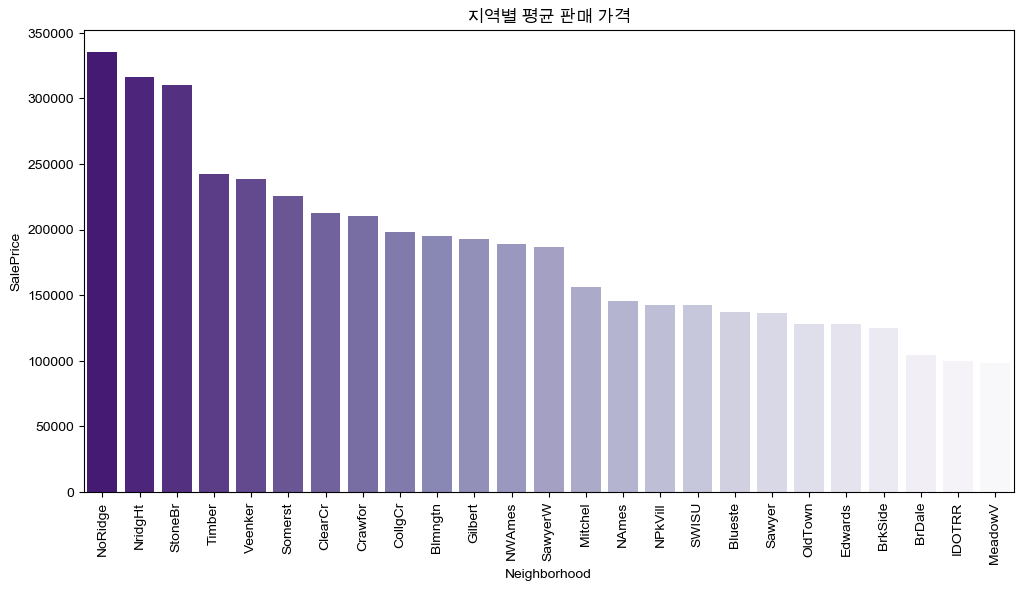

In [15]:
average_prices = df.groupby('Neighborhood')['SalePrice'].mean().reset_index()
average_prices = average_prices.sort_values(by=['SalePrice'], ascending=False).reset_index(drop=True)

# 전체 지역별 평균 판매 가격
Visualizer.plot_barplot(average_prices, 'Neighborhood', 'SalePrice', 
                        figsize=(12, 6), palette='Purples_r', rotation=90, title='지역별 평균 판매 가격')

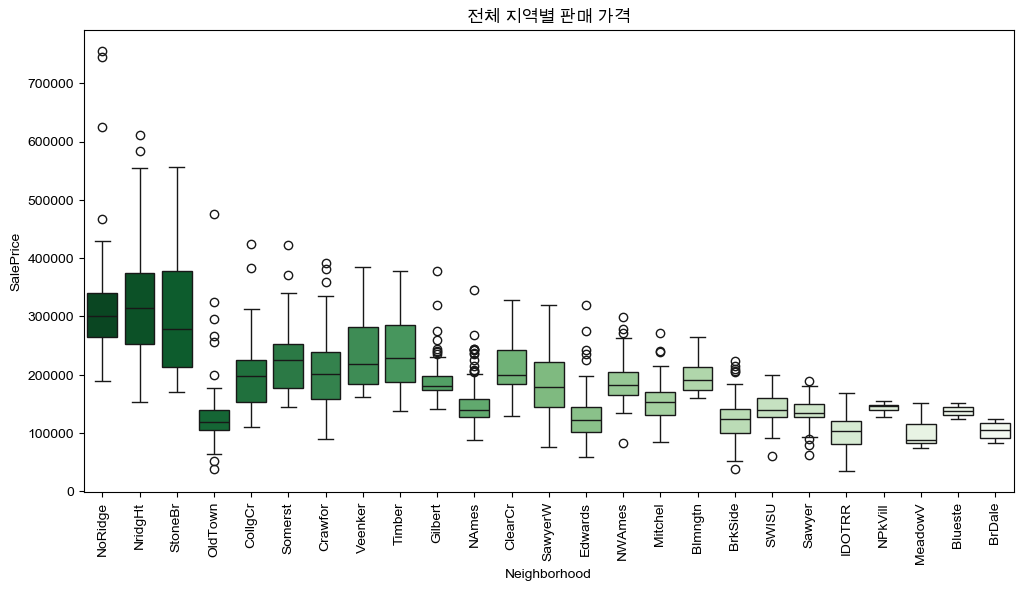

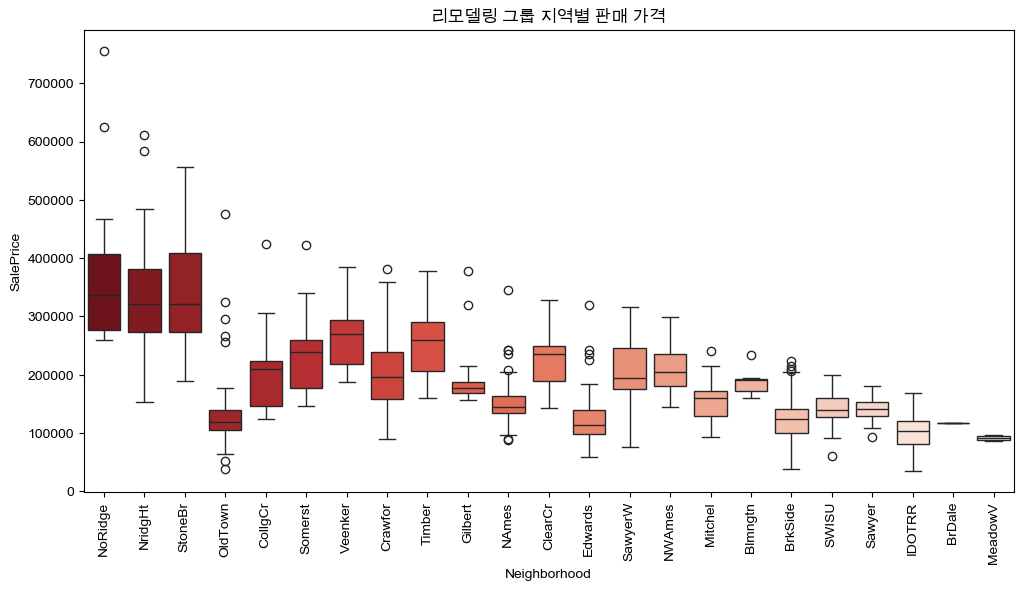

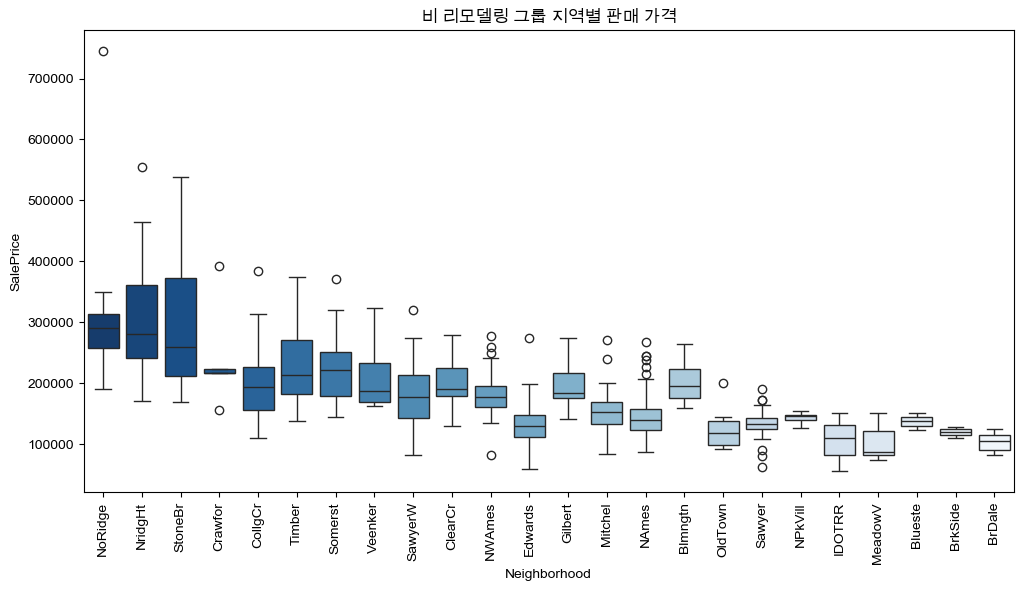

In [16]:
df.sort_values(by=['SalePrice'], ascending=False, inplace=True) # 리모델링 O
df_Remodel.sort_values(by=['SalePrice'], ascending=False, inplace=True) # 리모델링 O
df_Not_Remodel.sort_values(by=['SalePrice'], ascending=False, inplace=True) # 리모델링 X

# 위 boxplot 함수 호출 
Visualizer.plot_boxplot(df, 'Neighborhood', 'SalePrice', figsize=(12, 6), palette='Greens_r', rotation=90, title='전체 지역별 판매 가격') # 전체 데이터
Visualizer.plot_boxplot(df_Remodel, 'Neighborhood', 'SalePrice', figsize=(12, 6), palette='Reds_r', rotation=90, title='리모델링 그룹 지역별 판매 가격') # 리모델링 O
Visualizer.plot_boxplot(df_Not_Remodel, 'Neighborhood', 'SalePrice', figsize=(12, 6), palette='Blues_r', rotation=90, title='비 리모델링 그룹 지역별 판매 가격') # 리모델링 X

In [17]:
results = []

# 리모델링 여부가 지역별로 주택 판매 가격에 유의미한 영향을 미치는지 확인
for neighborhood in df['Neighborhood'].unique():
    remodeled_prices = df_Remodel[df_Remodel['Neighborhood'] == neighborhood]['SalePrice']
    not_remodeled_prices = df_Not_Remodel[df_Not_Remodel['Neighborhood'] == neighborhood]['SalePrice']

    # 데이터가 최소 2개 이상일 때만 검정
    if len(remodeled_prices) > 2 and len(not_remodeled_prices) > 2:
        h_stat, p_value = stats.kruskal(remodeled_prices, not_remodeled_prices)
    else:
        h_stat, p_value = np.nan, np.nan  # 검정 불가능한 경우 NaN 처리

    results.append({
        'Neighborhood': neighborhood,
        'H-statistic': round(h_stat, 3) if not np.isnan(h_stat) else '검정 불가',
        'p-value': round(p_value, 4) if not np.isnan(p_value) else np.nan,
        '결과': '유의미함' if not np.isnan(p_value) and p_value < 0.05 else '유의미하지 않음'
    })

kruskal_results = pd.DataFrame(results).sort_values(by='p-value', na_position='last').reset_index(drop=True)
kruskal_results

,Neighborhood,H-statistic,p-value,결과
0,NWAmes,9.063,0.0026,유의미함
1,NoRidge,5.666,0.0173,유의미함
2,SawyerW,3.949,0.0469,유의미함
3,NAmes,3.692,0.0547,유의미하지 않음
4,Gilbert,3.147,0.0761,유의미하지 않음
5,Sawyer,2.989,0.0838,유의미하지 않음
6,Edwards,2.775,0.0958,유의미하지 않음
7,Veenker,2.133,0.1441,유의미하지 않음
8,ClearCr,2.042,0.1530,유의미하지 않음
9,Timber,1.581,0.2087,유의미하지 않음


In [18]:
# 지역별 상위 
average_prices

,Neighborhood,SalePrice
0,NoRidge,335295.317073
1,NridgHt,316270.623377
2,StoneBr,310499.000000
3,Timber,242247.447368
4,Veenker,238772.727273
5,Somerst,225379.837209
6,ClearCr,212565.428571
7,Crawfor,210624.725490
8,CollgCr,197965.773333
9,Blmngtn,194870.882353


In [19]:
# 지역별 평균 판매 가격의 전체 평균
mean_price = average_prices['SalePrice'].mean()

h_test_top = kruskal_results[kruskal_results['결과'] == '유의미함']['Neighborhood'].tolist()
top_prices = average_prices[average_prices['SalePrice'] >= mean_price]

top_prices_area = top_prices[top_prices['Neighborhood'].isin(h_test_top)]
top_prices_area

,Neighborhood,SalePrice
0,NoRidge,335295.317073
11,NWAmes,189050.068493
12,SawyerW,186555.796610


### 결과

1. 유의미한 지역들의 평균 판매 가격 분석 결과, 이들 지역의 평균 판매 가격은 대부분 전체 지역의 평균 판매 가격 이상으로 나타남

2. 이는 리모델링의 효과가 뚜렷한 지역일수록 높은 판매 가격을 형성하고 있음을 시사

3. 리모델링 그룹과 비리모델링 그룹 간 판매 가격 비교 결과, 통계적으로 유의미한 차이가 존재함을 확인 (p-value = 0.0011)

4. 그러나 방향성 있는 검정(greater)에서는 귀무가설 기각 불가(p-value = 0.9995)로, 리모델링 그룹이 비리모델링 그룹보다 판매 가격이 높다고 단정할 수 없음.

### 결론

1. 리모델링의 효과는 지역의 주택 가격 수준에 따라 달라지며, 고가 지역일수록 그 효과가 더욱 뚜렷하게 나타난다.

2. 리모델링이 판매 가격에 미치는 영향은 존재하지만, 리모델링이 반드시 가격 상승으로 이어진다고 단정하기 어려움.

3. 따라서 리모델링 투자 전략은 지역의 주택 시장 특성을 고려하여 고가 주택 밀집 지역에 집중하는 것이 효과적일 수 있다.

4. 향후 리모델링 투자 또는 정책 결정 시, 지역별 가격 특성을 반영한 맞춤형 전략이 필요

-----------------

## 2.&nbsp; 리모델링 여부에 따른 연도별 가격 변화 분석

- **목적**: 리모델링한 집들의 판매 가격이 시간이 지남에 따라 어떻게 변화했는지, 패턴은 어떠한지 분석

In [20]:
# 연도 데이터 범위 확인
year_data = ['YearBuilt', 'YearRemodAdd', 'YrSold']

for col in year_data:
    print(f"{col}의 고유값 수: {df[col].nunique()}")
    print(df[col].unique())
    print('-' * 30)

YearBuilt의 고유값 수: 112
[1994 1996 1995 2009 2008 2005 2003 1892 2001 2006 1992 2007 2010 1981
 1935 1965 1934 2004 1997 1972 1993 1998 1999 1989 1959 1893 1990 1983
 1932 2000 2002 1939 1971 1986 1976 1880 1974 1975 1958 1988 1985 1966
 1977 1970 1941 1968 1991 1979 1980 1945 1957 1920 1954 1978 1936 1940
 1973 1950 1960 1967 1908 1918 1987 1926 1956 1929 1953 1948 1923 1969
 1916 1984 1925 1946 1914 1922 1964 1955 1921 1963 1919 1961 1942 1928
 1915 1962 1937 1931 1882 1910 1952 1951 1905 1930 1900 1890 1947 1904
 1949 1982 1912 1906 1911 1917 1924 1938 1885 1872 1927 1898 1875 1913]
------------------------------
YearRemodAdd의 고유값 수: 61
[1995 1996 2010 2009 2006 2008 2003 1993 2002 2007 2004 2005 1987 1997
 1965 1998 1994 1999 1990 2000 1976 1975 1981 1989 1985 1966 1991 1970
 2001 1992 1979 1980 1950 1984 1978 1973 1968 1988 1986 1953 1969 1977
 1960 1964 1971 1963 1974 1967 1962 1958 1959 1952 1957 1972 1954 1961
 1955 1982 1983 1951 1956]
------------------------------
YrSold의 고유값 

### 2-1. 판매 연도별 판매 가격 분석

In [21]:
# 연도별 분석 Class
class Year_Analysis:
    def __init__(self, df, df_remodel=None, df_not_remodel=None):
        self.df = df
        self.df_remodel = df_remodel
        self.df_not_remodel = df_not_remodel

    # 그룹화 함수
    def group_data(self, df, year_col, target_col):
        min_price = df.groupby(year_col)[target_col].min().reset_index().sort_values(by=year_col)
        mean_price = df.groupby(year_col)[target_col].mean().reset_index().sort_values(by=year_col)
        max_price = df.groupby(year_col)[target_col].max().reset_index().sort_values(by=year_col)
        return min_price, mean_price, max_price

    # 단일 시각화
    def plot_year(self, year_col, target_col, figsize=(10, 6), title=None):
        min_price, mean_price, max_price = self.group_data(self.df, year_col, target_col)

        plt.figure(figsize=figsize)
        sns.lineplot(x=min_price[year_col], y=min_price[target_col], marker='o', label='Min Price', color='skyblue')
        sns.lineplot(x=mean_price[year_col], y=mean_price[target_col], marker='o', label='Mean Price', color='green')
        sns.lineplot(x=max_price[year_col], y=max_price[target_col], marker='o', label='Max Price', color='Orange')
        plt.title(title if title else f"{year_col}별 {target_col} 추이", fontsize=14)
        plt.xlabel(year_col, fontsize=12)
        plt.ylabel(target_col, fontsize=12)
        plt.legend(title='가격 유형')
        plt.grid(True)
        plt.show()

    # 두 그룹간 평균 비교
    def plot_year_group(self, year_col, target_col, figsize=(10, 6), title=None):
        min_price_r, mean_price_r, max_price_r = self.group_data(self.df_remodel, year_col, target_col)
        min_price_nr, mean_price_nr, max_price_nr = self.group_data(self.df_not_remodel, year_col, target_col)

        plt.figure(figsize=figsize)
        sns.lineplot(x=mean_price_r[year_col], y=mean_price_r[target_col], marker='o', label='리모델링 그룹', color='tomato')
        sns.lineplot(x=mean_price_nr[year_col], y=mean_price_nr[target_col], marker='o', label='비 리모델링 그룹', color='skyblue')
        plt.title(title if title else f"{year_col}별 {target_col} 추이", fontsize=14)
        plt.xlabel(year_col, fontsize=12)
        plt.ylabel(target_col, fontsize=12)
        plt.legend(title='그룹 유형')
        plt.grid(True)
        plt.show()        

    # 리모델링 그룹과 비리모델링 그룹을 비교하는 서브플롯 함수
    def plot_year_comparison(self, year_col, target_col, figsize=(12, 8), title=None):
        fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)

        # 리모델링 그룹
        min_price_r, mean_price_r, max_price_r = self.group_data(self.df_remodel, year_col, target_col)
        axes[0].set_title('리모델링 그룹')
        sns.lineplot(x=min_price_r[year_col], y=min_price_r[target_col], marker='o', label='Min Price', color='skyblue', ax=axes[0])
        sns.lineplot(x=mean_price_r[year_col], y=mean_price_r[target_col], marker='o', label='Mean Price', color='green', ax=axes[0])
        sns.lineplot(x=max_price_r[year_col], y=max_price_r[target_col], marker='o', label='Max Price', color='Orange', ax=axes[0])
        axes[0].set_xlabel(year_col)
        axes[0].set_ylabel(target_col)
        axes[0].legend()
        axes[0].grid(True)

        # 비리모델링 그룹
        min_price_nr, mean_price_nr, max_price_nr = self.group_data(self.df_not_remodel, year_col, target_col)
        axes[1].set_title('비 리모델링 그룹')
        sns.lineplot(x=min_price_nr[year_col], y=min_price_nr[target_col], marker='o', label='Min Price', color='skyblue', ax=axes[1])
        sns.lineplot(x=mean_price_nr[year_col], y=mean_price_nr[target_col], marker='o', label='Mean Price', color='green', ax=axes[1])
        sns.lineplot(x=max_price_nr[year_col], y=max_price_nr[target_col], marker='o', label='Max Price', color='Orange', ax=axes[1])
        axes[1].set_xlabel(year_col)
        axes[1].legend()
        axes[1].grid(True)

        plt.suptitle(title if title else f"{year_col}별 {target_col} 비교", fontsize=16)
        plt.tight_layout()
        plt.show()

- 전체 판매 연도별 가격 개별 분석(min, mean, max)

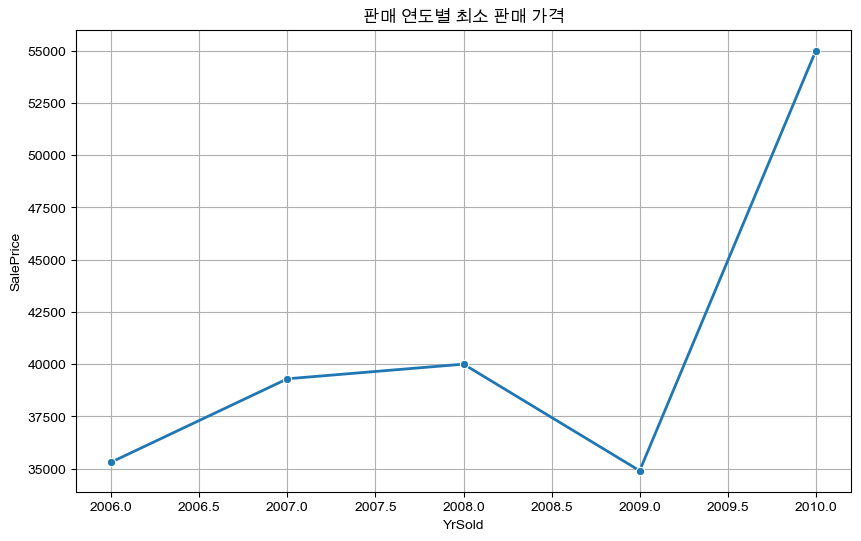

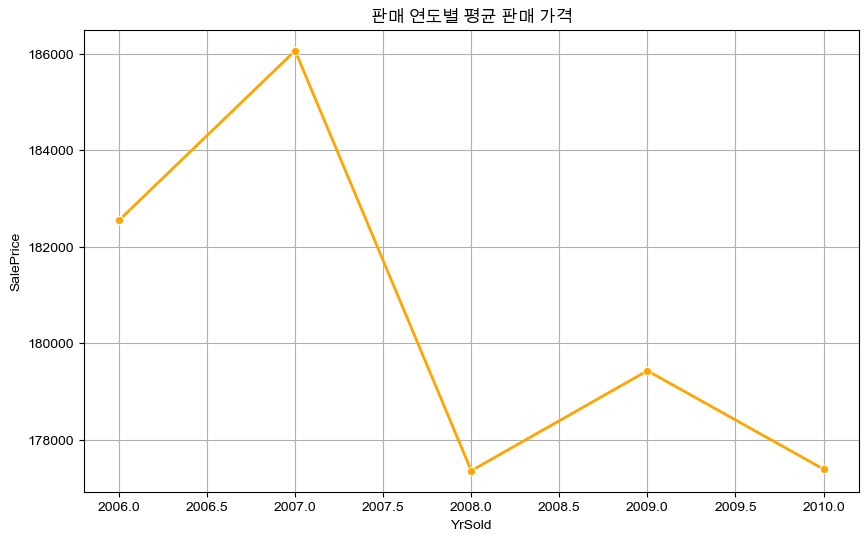

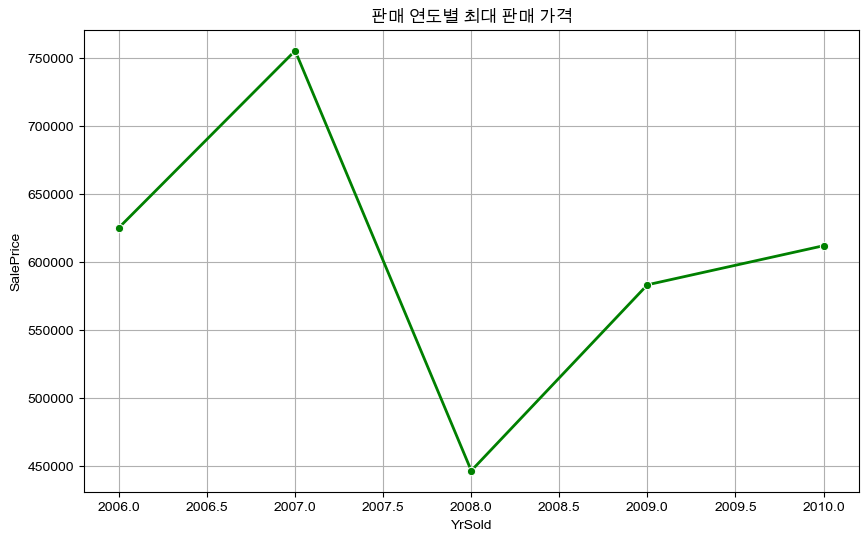

In [22]:
analysis = Year_Analysis(df)
cohort_min_price, cohort_mean_price, cohort_max_price = analysis.group_data(df, 'YrSold', 'SalePrice')

# 개별 시각화
Visualizer.plot_lineplot(cohort_min_price, 'YrSold', 'SalePrice', figsize=(10, 6), title='판매 연도별 최소 판매 가격')
Visualizer.plot_lineplot(cohort_mean_price, 'YrSold', 'SalePrice', figsize=(10, 6), title='판매 연도별 평균 판매 가격', color='Orange')
Visualizer.plot_lineplot(cohort_max_price, 'YrSold', 'SalePrice', figsize=(10, 6), title='판매 연도별 최대 판매 가격', color='Green')

- 리모델링 여부 판매 연도별 판매가격 시각화

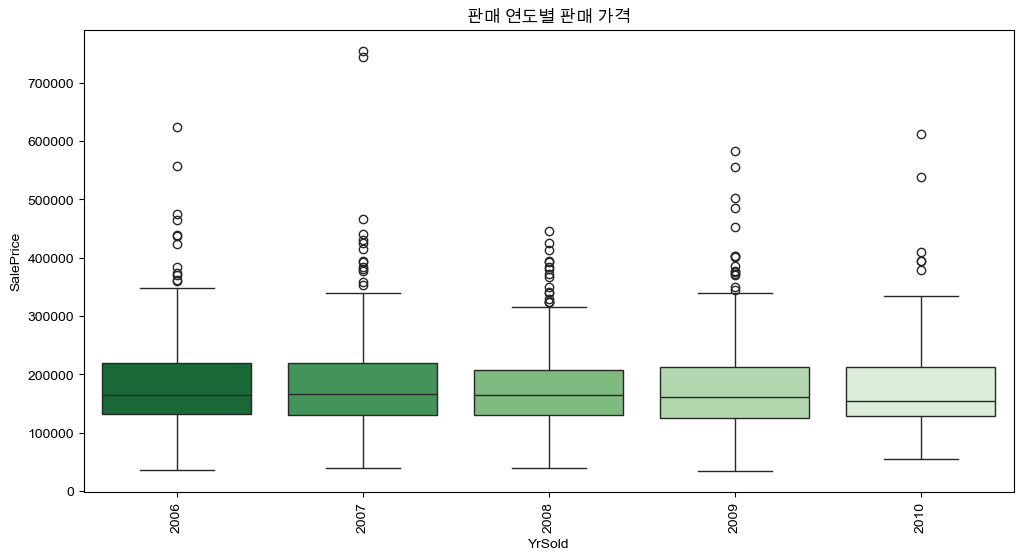

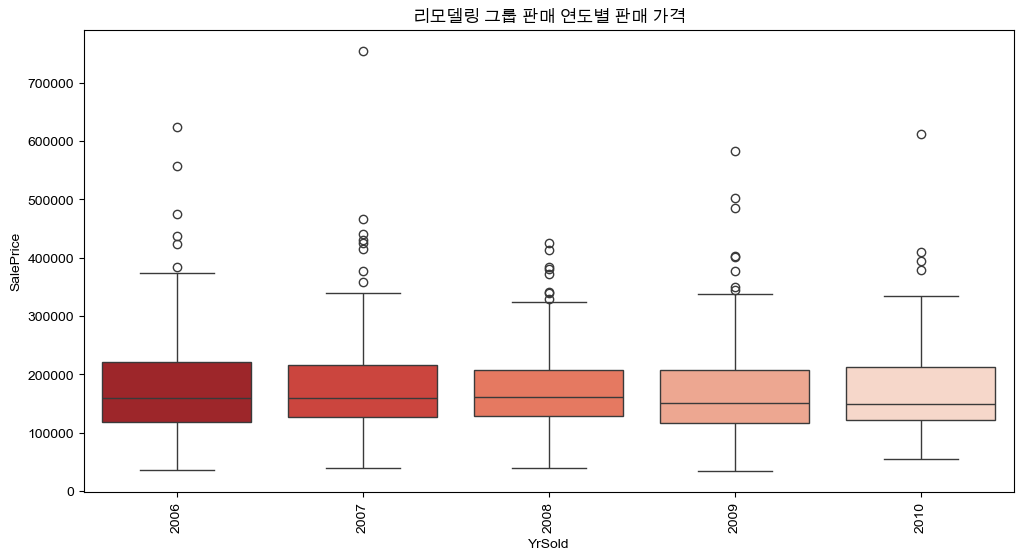

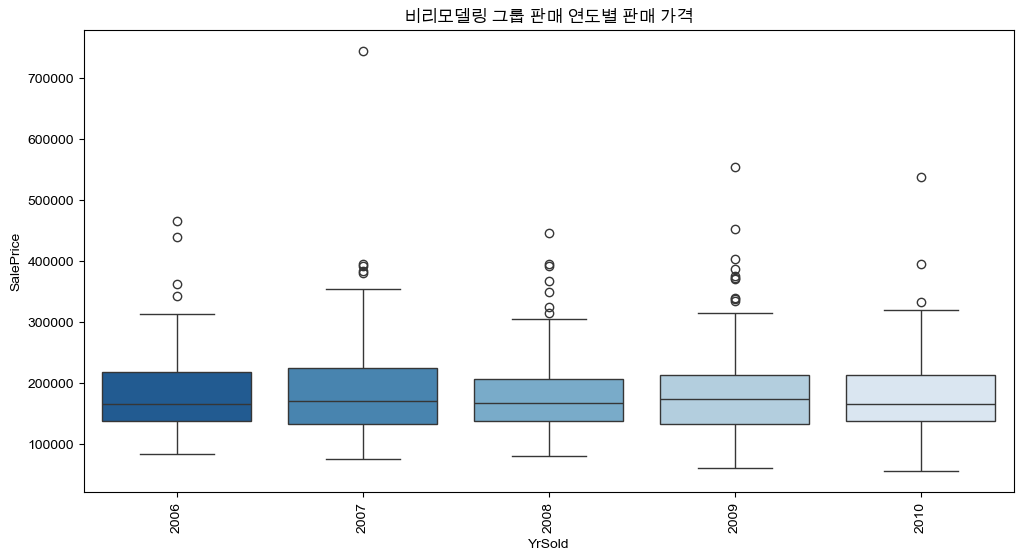

In [23]:
# 리모델링 여부 판매 연도별 판매 가격 시각화
Visualizer.plot_boxplot(df, 'YrSold', 'SalePrice', figsize=(12, 6), palette='Greens_r', rotation=90, title='판매 연도별 판매 가격') # 전체 데이터
Visualizer.plot_boxplot(df_Remodel, 'YrSold', 'SalePrice', figsize=(12, 6), palette='Reds_r', rotation=90, title='리모델링 그룹 판매 연도별 판매 가격') # 리모델링 O
Visualizer.plot_boxplot(df_Not_Remodel, 'YrSold', 'SalePrice', figsize=(12, 6), palette='Blues_r', rotation=90, title='비리모델링 그룹 판매 연도별 판매 가격') # 리모델링 X

### 2-2. 리모델링 연도별 판매 가격 분석

- 리모델링 여부에 따른 평균 판매 가격 변화

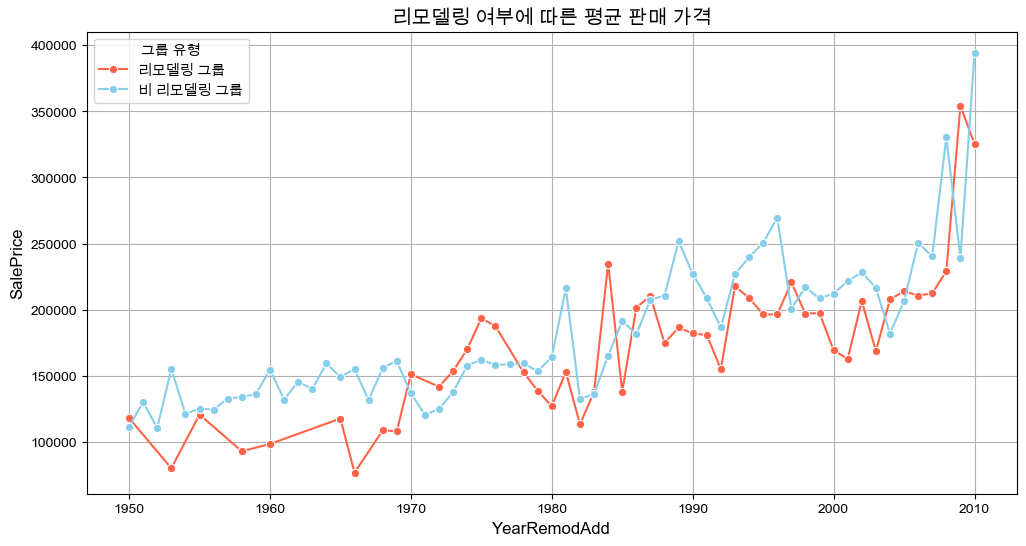

In [24]:
# 리모델링 여부에 따른 평균 판매 가격 변화
analysis = Year_Analysis(df, df_remodel=df_Remodel, df_not_remodel=df_Not_Remodel)
analysis.plot_year_group(year_col='YearRemodAdd', target_col='SalePrice', figsize=(12, 6), title='리모델링 여부에 따른 평균 판매 가격')

- 리모델링 여부에 따른 최소, 평균, 최대 판매 가격 비교

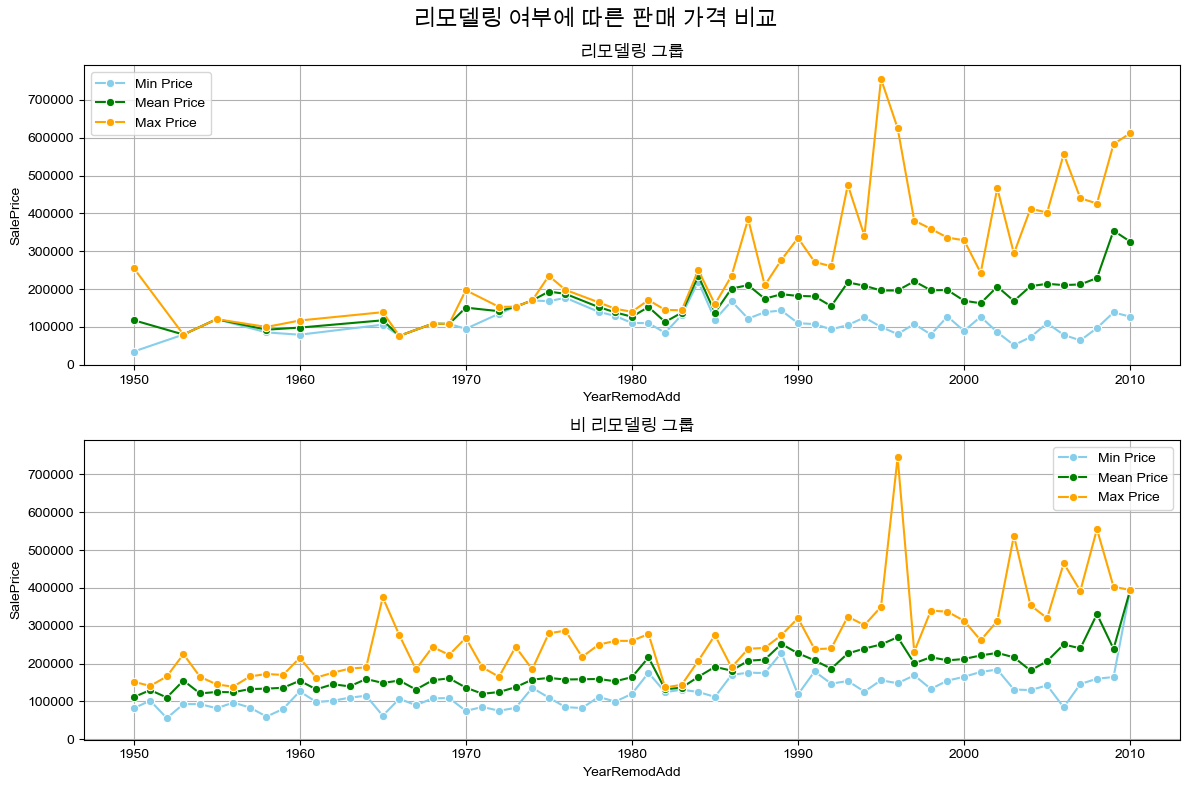

In [25]:
# 리모델링 여부 비교
analysis = Year_Analysis(df, df_remodel=df_Remodel, df_not_remodel=df_Not_Remodel)
analysis.plot_year_comparison(year_col='YearRemodAdd', target_col='SalePrice', figsize=(12, 8), title='리모델링 여부에 따른 판매 가격 비교')

- 두 그룹 별 이상치 확인

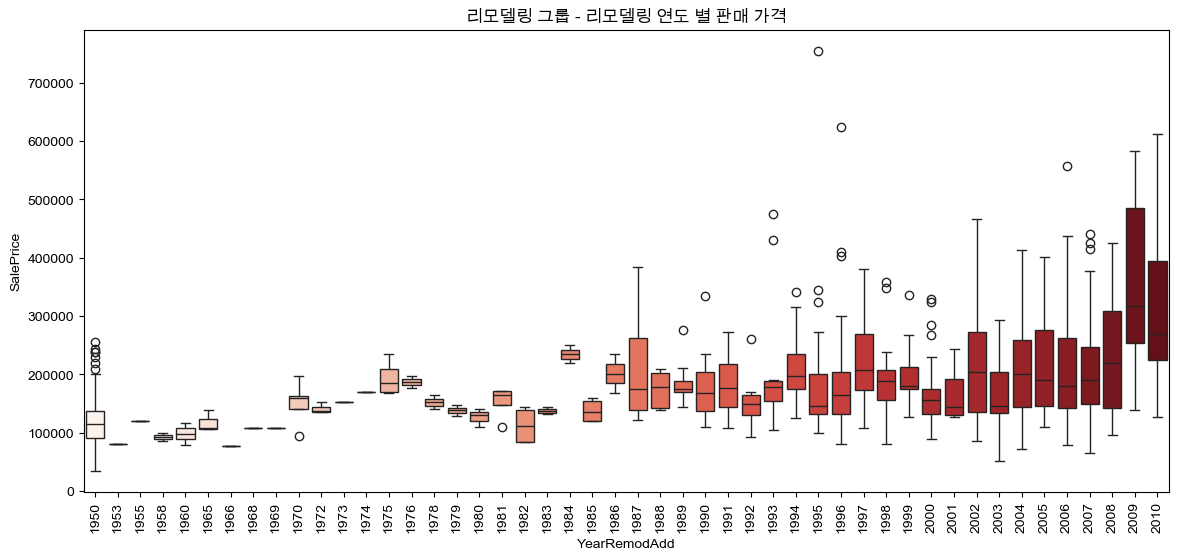

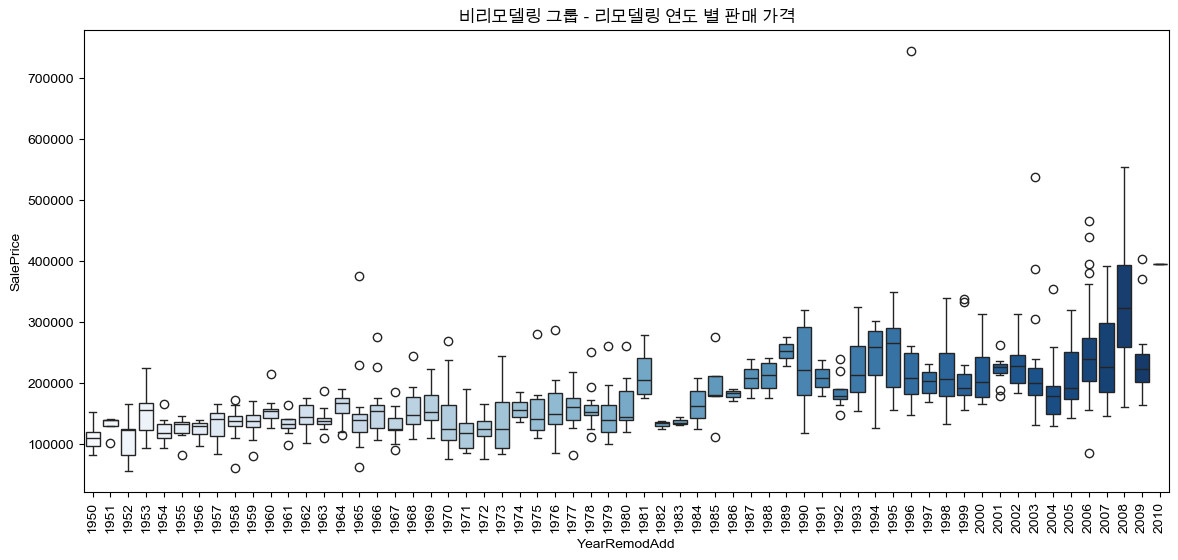

In [26]:
Visualizer.plot_boxplot(df_Remodel, 'YearRemodAdd', 'SalePrice', figsize=(14, 6), rotation=90, title='리모델링 그룹 - 리모델링 연도 별 판매 가격', palette='Reds')
Visualizer.plot_boxplot(df_Not_Remodel, 'YearRemodAdd', 'SalePrice', figsize=(14, 6), rotation=90, title='비리모델링 그룹 - 리모델링 연도 별 판매 가격', palette='Blues')

In [27]:
print(f"리모델링 그룹 판매가격 통계:\n {df_Remodel['SalePrice'].describe()}") # 리모델링 그룹
print('-' * 30)
print(f"비 리모델링 그룹 판매가격 통계:\n {df_Not_Remodel['SalePrice'].describe()}") # 비 리모델링 그룹

리모델링 그룹 판매가격 통계:
 count       696.000000
mean     179096.307471
std       88383.080722
min       34900.000000
25%      121900.000000
50%      155000.000000
75%      213062.500000
max      755000.000000
Name: SalePrice, dtype: float64
------------------------------
비 리모델링 그룹 판매가격 통계:
 count       764.000000
mean     182583.659686
std       70333.800127
min       55993.000000
25%      135500.000000
50%      170000.000000
75%      214000.000000
max      745000.000000
Name: SalePrice, dtype: float64


### 2-3. 그룹 간 판매 가격 차이를 연도별로 유의미한지 검정

In [28]:
results = []

# 연도 리스트 (예: 2000 ~ 2010)
years = df['YearRemodAdd'].unique()

# 연도별 U-검정 수행
for year in sorted(years):
    group1 = df_Remodel[df_Remodel['YearRemodAdd'] == year]['SalePrice']
    group2 = df_Not_Remodel[df_Not_Remodel['YearRemodAdd'] == year]['SalePrice']
    
    # 두 그룹의 데이터가 충분한지 확인
    if len(group1) > 2 and len(group2) > 2:
        u_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
        result = '유의미함' if p_value < 0.05 else '유의미하지 않음'
    else:
        u_stat, p_value, result = None, None, '검정 불가'
    
    results.append({'Year': year, 'U-statistic': u_stat, 'p-value': p_value, '결과': result})

result_df = pd.DataFrame(results).sort_values(by=['결과'], ascending=False).reset_index(drop=True)
result_df

,Year,U-statistic,p-value,결과
0,1981,0.0,0.029401,유의미함
1,1995,30.0,0.026051,유의미함
2,2009,100.0,0.021489,유의미함
3,2008,92.0,0.006015,유의미함
4,2007,520.0,0.043221,유의미함
...,...,...,...,...
56,1974,NaN,NaN,검정 불가
57,1951,NaN,NaN,검정 불가
58,1979,NaN,NaN,검정 불가
59,1978,NaN,NaN,검정 불가


In [29]:
# 검정 불가 항목은 제외
Not_nan_result = result_df[result_df['결과'] != '검정 불가']
Not_nan_result

,Year,U-statistic,p-value,결과
0,1981,0.0,0.029401,유의미함
1,1995,30.0,0.026051,유의미함
2,2009,100.0,0.021489,유의미함
3,2008,92.0,0.006015,유의미함
4,2007,520.0,0.043221,유의미함
5,2006,734.0,0.001535,유의미함
6,2003,184.0,0.009242,유의미함
7,2001,14.0,0.004346,유의미함
8,2000,148.5,0.000236,유의미함
9,1992,13.0,0.027396,유의미함


### 결과

1. 전체적으로 비 리모델링 그룹의 평균 판매 가격이 리모델링 그룹보다 높은 경향을 나타냄.

2. 이는 리모델링 여부 자체가 가격 상승의 직접적인 요인이라기보다는, 비 리모델링 그룹의 데이터가 더 많기 때문에 단정 지을 수 없음.

3. 최대 판매 가격은 리모델링 그룹에서 더 높은 변동성을 보였으며, 이는 일부 리모델링 사례에서 상당한 가격 상승이 있었음을 의미.

4. 특히 2000년대 초반 이후로 갈수록 두 그룹 간 가격 차이가 더 뚜렷해짐.(검정 결과 대부분 2000년대로 나타남)

### 결론

1. 리모델링 여부는 전체적으로 판매 가격에 일정한 영향을 미치지 않음. 그러나 특정 연도에서는 유의미한 가격 차이가 관찰됨.

2. 다음 단계에서는 리모델링 효과를 더 깊이 이해하기 위해 패턴 분석과 분류 모델링을 통해 분석을 확장할 필요가 있음.

---------------

## 3.&nbsp; 시계열 분석

원인: 
- 앞선 분석 결과, 리모델링 여부가 판매 가격에 일정 부분 영향을 미치긴 하지만, 모든 연도에서 일관된 패턴이 나타나지 않았다는 점을 확인
- 특히 일부 연도에서는 유의미한 차이가 있었지만, 그렇지 않은 연도도 다수 존재
- 이는 리모델링 효과가 단순히 여부만으로 설명될 수 없고, 리모델링 후 경과 시간이라는 추가적인 요인이 중요하다는 것을 시사

목적: 
- 리모델링 직후와 시간이 지남에 따라 판매 가격 변화 패턴을 분석하여, 리모델링의 단기 효과와 장기 효과를 구분
- 단순한 시점 간 비교가 아닌, 경과 시간(Elapsed Years)을 기준으로 구간을 나누어 시간 흐름에 따른 리모델링 효과의 지속성을 평가
- 이를 통해 리모델링이 시간이 지남에 따라 가치가 유지되는지, 또는 효과가 감소하는지에 대한 인사이트를 도출

선정 기준:
- Elapsed Years = YrSold - YearRemodAdd
- 이는 리모델링 후 경과된 시간을 의미하며, 리모델링이 판매 가격에 미치는 영향을 시간의 흐름에 따라 분석할 수 있게 해줌

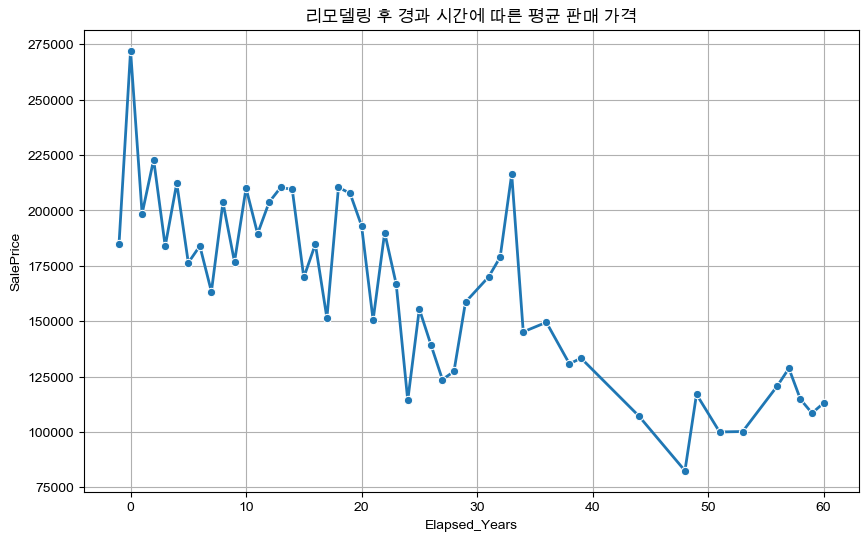

            YrSold  YearRemodAdd  Elapsed_Years
count   696.000000    696.000000     696.000000
mean   2007.844828   1986.666667      21.178161
std       1.303698     22.297939      22.214517
min    2006.000000   1950.000000      -1.000000
25%    2007.000000   1965.000000       4.000000
50%    2008.000000   1996.000000      11.000000
75%    2009.000000   2004.000000      44.000000
max    2010.000000   2010.000000      60.000000

리모델링 경과 시간의 고유 값 개수: 48


In [30]:
df_Remodel['Elapsed_Years'] = df_Remodel['YrSold'] - df_Remodel['YearRemodAdd']
# df['Elapsed_Years'] = df_Remodel['Elapsed_Years'] # 원본 데이터에도 추가
time_analysis = df_Remodel.groupby('Elapsed_Years')['SalePrice'].mean().reset_index() # 평균 가격 계산

# 위 함수 사용
Visualizer.plot_lineplot(time_analysis, 'Elapsed_Years', 'SalePrice', 
                         figsize=(10, 6), title='리모델링 후 경과 시간에 따른 평균 판매 가격')

print(f"{df_Remodel[['YrSold', 'YearRemodAdd', 'Elapsed_Years']].describe()}\n")
print(f"리모델링 경과 시간의 고유 값 개수: {df_Remodel['Elapsed_Years'].nunique()}")

### 3-1. 경과 시간 구간화 분석
- 위 통계값 확인 결과 음수 값이 확인됨 하지만 음수 값이 1개 이기에 큰 차이는 없을 거 같아 무시하고 진행

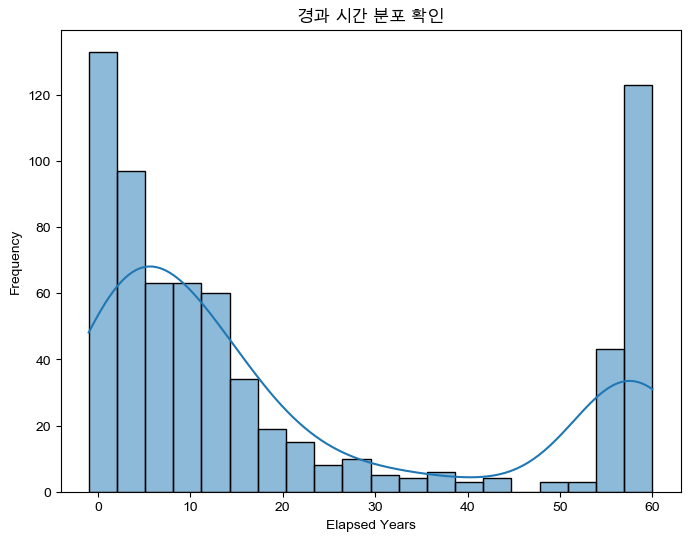

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(df_Remodel['Elapsed_Years'], bins=20, kde=True)
plt.title('경과 시간 분포 확인')
plt.xlabel('Elapsed Years')
plt.ylabel('Frequency')
plt.show()

- 경과 시간 구간 별 평균 판매 가격

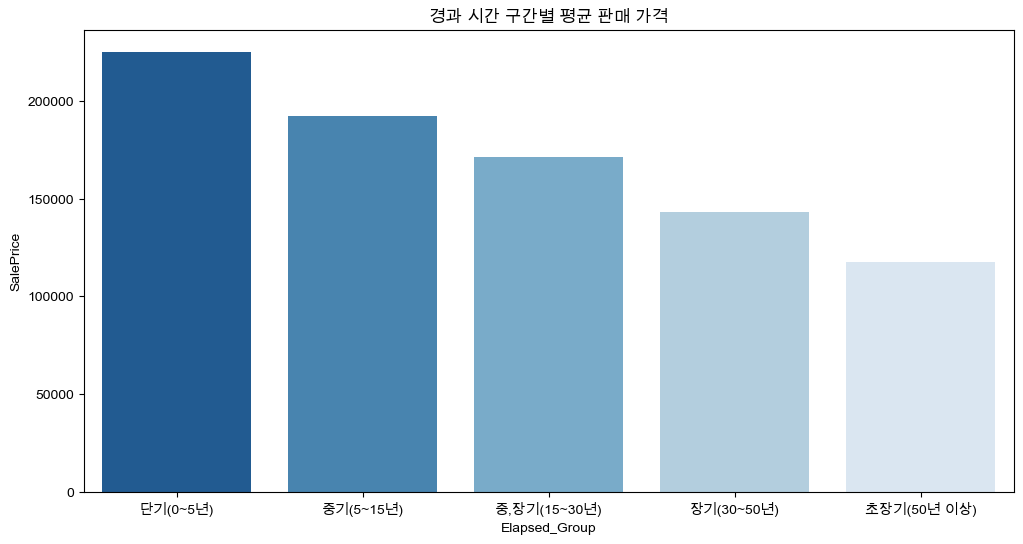

In [32]:
# 경과 시간 구간화 (리모델링 후 경과 연수 기준)
bins = [-1, 5, 15, 30, 50, df_Remodel['Elapsed_Years'].max() + 1] # 최대값 포함
labels = ['단기(0~5년)', '중기(5~15년)', '중,장기(15~30년)', '장기(30~50년)', '초장기(50년 이상)']
df_Remodel['Elapsed_Group'] = pd.cut(df_Remodel['Elapsed_Years'], bins=bins, labels=labels, right=False)

# 구간별 평균 판매 가격 분석
grouped_cohort = df_Remodel.groupby('Elapsed_Group')['SalePrice'].mean().reset_index() 
Visualizer.plot_barplot(grouped_cohort, 'Elapsed_Group', 'SalePrice', figsize=(12, 6), title='경과 시간 구간별 평균 판매 가격', palette='Blues_r')

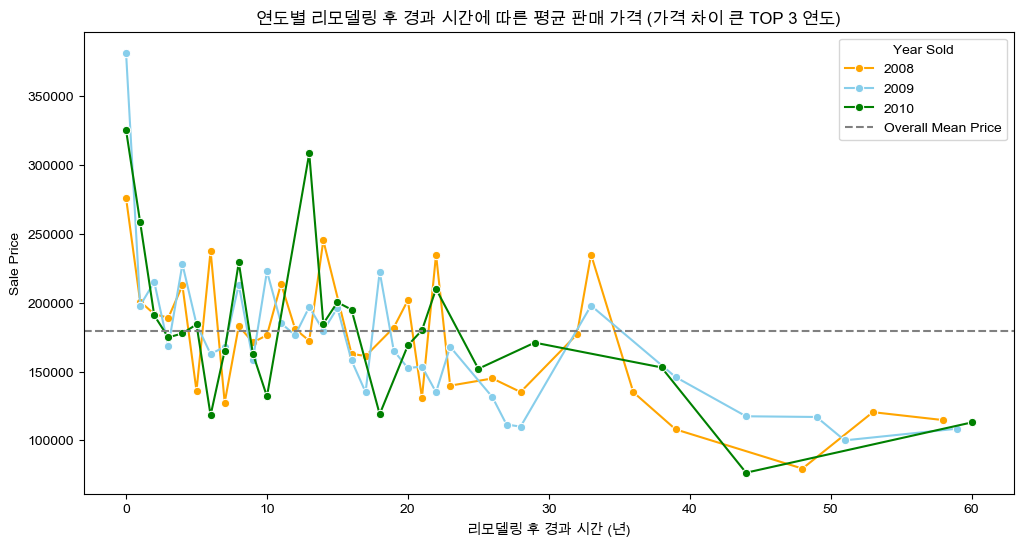

In [33]:
remodel_price_by_year = df_Remodel.groupby('YrSold')['SalePrice'].mean()
remodel_price_by_year_diff = remodel_price_by_year.diff().abs() # 연도별 가격 변화량(전년도 대비 차이) 계산
top3_years = remodel_price_by_year_diff.nlargest(3).index # 가격 변화량이 가장 큰 상위 3개 연도 

# TOP 3 연도의 리모델링 후 경과 연수에 따른 평균 가격 변화 
top3_cohort = df_Remodel[df_Remodel['YrSold'].isin(top3_years)]
grouped_top3 = top3_cohort.groupby(['YrSold', 'Elapsed_Years'])['SalePrice'].mean().reset_index()

custom_palette = {top3_years[0]: "#FFA500",  # Orange
                  top3_years[1]: "#008000",  # Green
                  top3_years[2]: "#87CEEB"}  # Sky Blue

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_top3, x='Elapsed_Years', y='SalePrice', hue='YrSold', palette=custom_palette, marker='o')
plt.axhline(df_Remodel['SalePrice'].mean(), color='gray', linestyle='--', label='Overall Mean Price')
plt.title('연도별 리모델링 후 경과 시간에 따른 평균 판매 가격 (가격 차이 큰 TOP 3 연도)')
plt.xlabel('리모델링 후 경과 시간 (년)')
plt.ylabel('Sale Price')
plt.legend(title='Year Sold')
plt.show()

### 3-2. 통계적 검증

In [34]:
class Stats_Analysis:
    def __init__(self, df=None):
        self.df = df
    
    # 시각화
    def pearson_corr(self, df, target_col, threshold=0, cmap='Reds'):
        df = df.select_dtypes(include=['number'])
        corr_series = df.corr()[target_col].drop(target_col)  # 자기 자신 제외
        corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)  # 기준 필터

        # 히트맵 시각화
        plt.figure(figsize=(10, 10))
        sns.heatmap(corr_filtered.to_frame(name='Correlation'), 
                    annot=True, fmt='.2f', cmap=cmap, 
                    annot_kws={"size": 12}, cbar=True)
        plt.title(f'Correlation with {target_col}', fontsize=16)
        plt.show()

        corr_df = corr_filtered.reset_index()
        corr_df.columns = ['Variable', 'Correlation']
        return corr_df
    
    # 상관분석 검정
    def pearson_test(self, df, col1, col2):
        corr, p_value = stats.pearsonr(df[col1], df[col2])
        print(f"피어슨 상관계수: {corr:.4f},\t p-value: {p_value:.4f}")

        if p_value < 0.05:
            print("귀무가설 기각: 유의미한 상관관계가 있음")
        else:
            print("귀무가설 기각 불가: 유의미한 상관관계가 없음!")

    # 선형 시각화 
    def linear_plot(self, df, target_col, features, figsize=(10, 8), nrows=4, ncols=3):
        num_plots = len(features)
        plt.figure(figsize=figsize)

        for i, col in enumerate(features):
            plt.subplot(nrows, ncols, i + 1)
            sns.regplot(
                x=df[col], 
                y=df[target_col], 
                scatter_kws={'s': 10}, 
                line_kws={'color': 'red'}
            )
            plt.title(f'{col} vs {target_col}')

        plt.tight_layout()
        plt.show()


- 피어슨 상관 분석

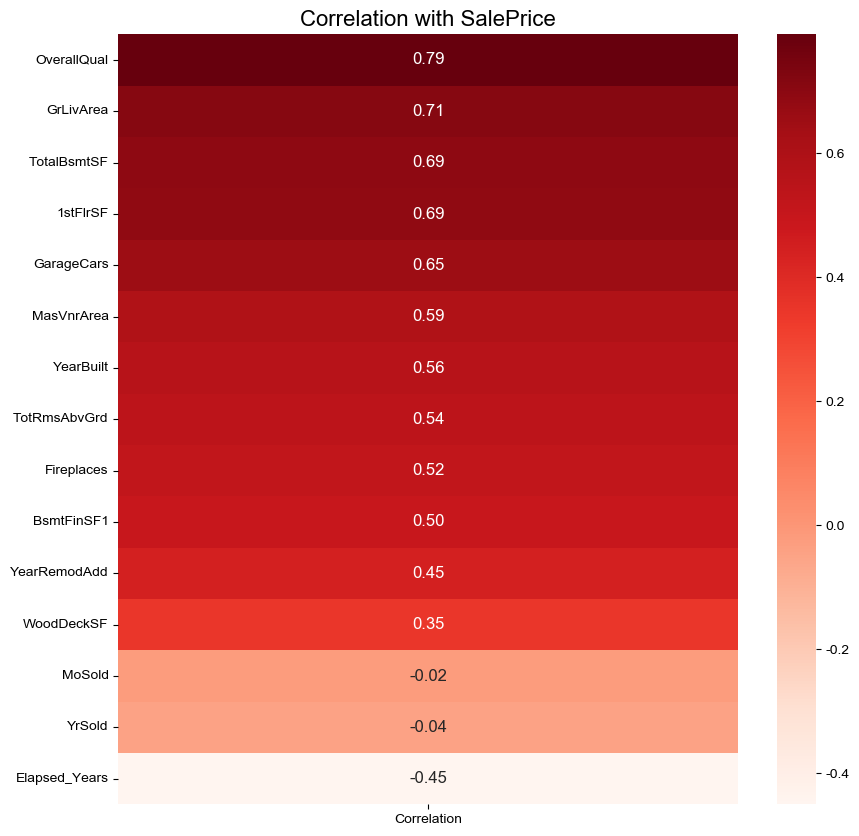

피어슨 상관계수: -0.4500,	 p-value: 0.0000
귀무가설 기각: 유의미한 상관관계가 있음


In [35]:
stat = Stats_Analysis()
Remodel_corr = stat.pearson_corr(df_Remodel, target_col='SalePrice')
stat.pearson_test(df_Remodel, 'Elapsed_Years', 'SalePrice')

- 선형 관계

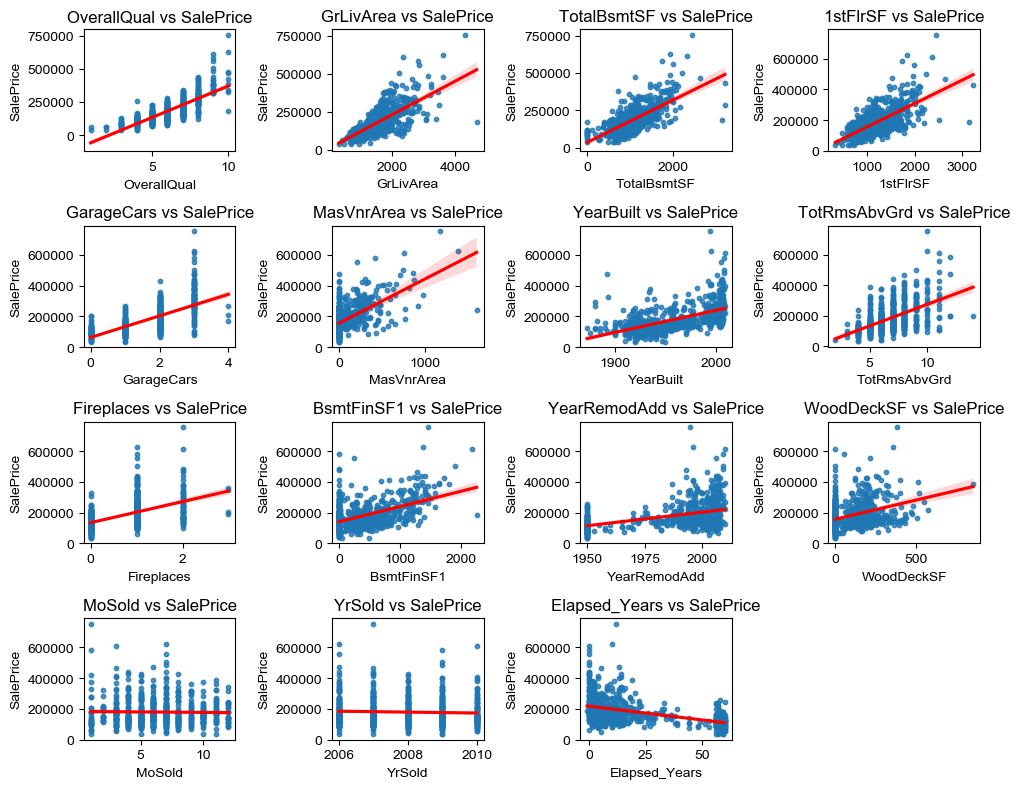

In [36]:
Remodel_linear = df_Remodel.select_dtypes(include=['number'])
Remodel_corr = Remodel_corr['Variable'].tolist()
stat.linear_plot(Remodel_linear, 'SalePrice', Remodel_corr, ncols=4, nrows=4)

- 선형 회귀 분석

In [37]:
# 회귀 분석
X = sm.add_constant(df_Remodel['Elapsed_Years'])
y = df_Remodel['SalePrice']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     176.2
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           5.33e-36
Time:                        21:13:05   Log-Likelihood:                -8835.4
No. Observations:                 696   AIC:                         1.767e+04
Df Residuals:                     694   BIC:                         1.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.17e+05   4137.905     52.445

### 3-3. OLS 회귀 모델 평가

- 위 회귀 분석 결과 R-squared 값이 0.2로 나타남 이는 모델이 데이터를 잘 설명하지 못한다는 근거
- 하여 아래 3가지 방법으로 성능을 평가

1. 잔차의 정규성 검정
2. 잔차의 등분산성 검정
3. 독립성 검정

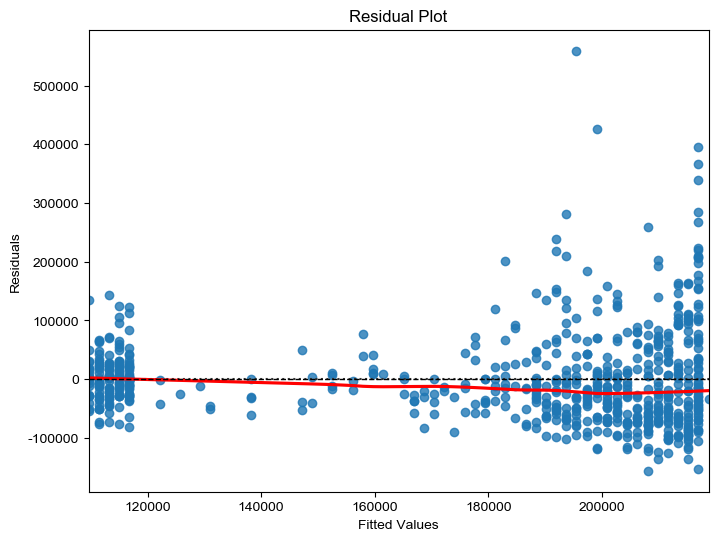

In [38]:
residuals = model.resid

# 잔차 플롯 (Residual Plot)
plt.figure(figsize=(8, 6))
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={"color": "red"})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

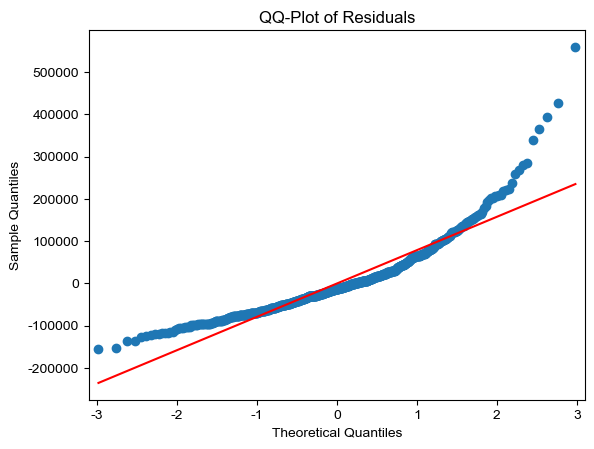

In [39]:
# QQ-Plot (정규성 확인)
sm.qqplot(residuals, line='s')
plt.title("QQ-Plot of Residuals")
plt.show()

In [40]:
# Shapiro-Wilk Test (잔차 정규성 검정)
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: p-value={shapiro_test.pvalue:.4f}")

if shapiro_test.pvalue < 0.05:
    print(f"귀무가설 기각 불가: 잔차는 정규분포를 따르지 않는다.")
else:
    print(f"귀무가설 기각: 잔차는 정규분포를 따른다.")

print('-' * 60)

# Breusch-Pagan Test (등분산성 검정)
bp_test = het_breuschpagan(residuals, model.model.exog)
print(f"Breusch-Pagan Test: p-value={bp_test[1]:.4f}")

if bp_test[1] < 0.05:
    print(f"귀무가설 기각 불가: 잔차는 등분산성을 만족하지 않는다.")
else:
    print(f"귀무가설 기각: 잔차는 등분산성을 만족한다.")

Shapiro-Wilk Test: p-value=0.0000
귀무가설 기각 불가: 잔차는 정규분포를 따르지 않는다.
------------------------------------------------------------
Breusch-Pagan Test: p-value=0.0000
귀무가설 기각 불가: 잔차는 등분산성을 만족하지 않는다.


### 결과

1. 시계열 분석: 
- 리모델링 후 경과 시간이 증가할수록 평균 판매 가격이 낮아지는 경향이 있음
- 시계열 간 가격 변동성이 존재하며, 일정한 패턴을 가지지 않음, 리모델링 후 약 30년이 지나면 가격이 급격히 하락하는 경향이 보임

2. OLS 회귀 분석:
- 경과 시간이 증가할수록 판매 가격이 감소하는 유의미한 관계 확인 (p < 0.05)
- 하지만 설명력(R² = 0.202)이 낮아, 단순 선형 회귀만으로는 충분한 설명이 어려움

3. 모델 평가(잔차 분석)
- 정규성 검정: 잔차는 정규성을 따르지 않음
- 등분산성 검정: 등분산성이 만족되지 않음
- 해석: 선형 회귀 모델의 기본 가정이 충족되지 않아, 분석 결과 신뢰도가 낮음.

### 결론
- 리모델링 후 경과 시간이 길어질수록 판매 가격이 감소하는 경향이 존재하지만, 단순 선형 회귀만으로는 충분한 설명이 어렵다.
- 잔차 분석 결과, 선형 회귀 모델의 신뢰성이 낮아 더 정교한 방법이 필요
- 현재 분석 주제는 잔차 분석이 주목적이 아님
- 이를 위해, 단순 가격 변화율 예측이 아닌 리모델링 여부가 주택 가격에 미치는 영향을 분석하는 회귀 모델을 적용하여 리모델링의 실질적인 가치 상승 기여도를 정량적으로 평가

--------------------

## 4.&nbsp; Regression Model

- 목적: 
    - 리모델링이 주택 가격(SalePrice)에 미치는 영향을 분석하여, 리모델링이 실제로 가격 상승에 기여하는지 정량적으로 평가
    - 기존 OLS의 한계를 보완하고, 가격 상승률을 예측하는 회귀 모델(Random Forest, XGBoost)을 활용

- 선정 기준:  
    - 리모델링 여부(Remodel_Label=1/0)를 주요 독립 변수로 설정하여 가격 변화에 미치는 영향을 분석
    - Neighborhood, YearBuilt, OverallQual 등 가격에 영향을 미치는 주요 변수들을 포함하여 리모델링 효과를 분리
    - 종속 변수는 주택의 최종 판매 가격(SalePrice)을 사용
    - SHAP 분석을 활용하여 리모델링의 상대적인 중요도 평가

- 모델 후보:  
    - `Random Forest Regressor`  
    - `XGBoost Regressor`  
    - `GradientBoosting`
    - `LGBM`

- 모델 학습 및 평가:  
    - K-Fold Cross Validation (K=5) 적용하여 데이터가 적은 문제 보완  
    - RMSE, R², MAE 등 회귀 모델 평가 지표 활용  
    - 모델 해석을 위해 SHAP 값을 활용하여 리모델링이 가격에 미치는 기여도를 분석

In [41]:
# 기초 통계값 확인(평균, 중앙값)
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### 4-1. Model 선정

- 각 모델을 K-Fold Cross Validation(K=5)으로 학습 및 평가
- TOP 2 Model 선정

- 평가 지표: RMSE

- 모델 후보:  
    - `Random Forest Regressor`  
    - `XGBoost Regressor`  
    - `GradientBoosting`
    - `LGBM`

In [42]:
# 분리
object_feature = df.select_dtypes(include=['object'])
num_feature = df.select_dtypes(include=['number']).drop(columns=['MoSold', 'YrSold']) # 시계열 데이터 제외

print(f"Object Data: {object_feature.shape[1]}")
print(f"Number Data: {num_feature.shape[1]}")

Object Data: 37
Number Data: 14


In [ ]:
# 주요 변수 병합
feature = pd.concat([object_feature, num_feature], axis=1)
X = feature.drop(columns=['SalePrice'])
y = feature['SalePrice'] # 종속 변수

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 분리
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

print(f"Train 데이터: {X_train.shape}, {y_train.shape}")
print(f"Validation 데이터: {X_val.shape}, {y_val.shape}")
print(f"Test 데이터: {X_test.shape}, {y_test.shape}")

X_train

Train 데이터: (1022, 50), (1022,)
Validation 데이터: (219, 50), (219,)
Test 데이터: (219, 50), (219,)


,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,GarageType,MSSubClass,Foundation,FireplaceQu,HeatingQC,...,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,WoodDeckSF,Remodel_Label
332,NridgHt,Gd,Gd,Gd,RFn,Attchd,20,PConc,Gd,Ex,...,3206,1629,7,2003,2004,296.0,1,1124,0,1
705,IDOTRR,Fa,No_BsmtQual,Fa,No_GarageFinish,No_GarageType,190,Slab,No_FireplaceQu,Fa,...,0,372,7,1930,1950,0.0,0,0,0,1
681,SWISU,TA,TA,TA,Unf,Detchd,50,BrkTil,No_FireplaceQu,Ex,...,793,848,6,1932,2000,0.0,0,182,0,1
570,NAmes,TA,TA,TA,Unf,Detchd,90,CBlock,No_FireplaceQu,TA,...,1728,1728,10,1965,1965,108.0,0,231,0,0
447,Gilbert,Gd,Gd,Gd,Fin,Attchd,60,PConc,TA,Gd,...,930,956,10,1998,1999,0.0,1,0,89,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,OldTown,TA,TA,TA,Unf,Detchd,50,BrkTil,TA,Gd,...,952,1022,8,1931,1950,0.0,2,0,90,1
165,Edwards,TA,TA,TA,No_GarageFinish,No_GarageType,190,BrkTil,No_FireplaceQu,Gd,...,644,808,6,1940,1999,0.0,0,351,140,1
394,OldTown,TA,TA,TA,Unf,Detchd,50,CBlock,No_FireplaceQu,Gd,...,735,735,5,1940,1950,0.0,0,0,0,1
865,NAmes,TA,TA,TA,Unf,Detchd,20,CBlock,No_FireplaceQu,TA,...,1002,1002,5,1970,1970,76.0,0,828,0,0


In [ ]:
# Train 데이터에서 실제 존재하는 범주형 컬럼 추출
cat_cols = list(set(object_feature.columns) & set(X_train.columns))

# 원핫 인코더
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(X_train[cat_cols])

# 변환된 데이터를 DataFrame으로 변환
X_train_encoded = pd.DataFrame(encoder.transform(X_train[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_train.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_test.index)
X_val_encoded = pd.DataFrame(encoder.transform(X_val[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_val.index)

# 기존 데이터에서 범주형 컬럼 삭제 후 병합
X_train = X_train.drop(columns=cat_cols).reset_index(drop=True)
X_test = X_test.drop(columns=cat_cols).reset_index(drop=True)
X_val = X_val.drop(columns=cat_cols).reset_index(drop=True)

X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)
X_val = pd.concat([X_val.reset_index(drop=True), X_val_encoded.reset_index(drop=True)], axis=1)

print(f"최종 Train 데이터: {X_train.shape}")
print(f"최종 Test 데이터: {X_test.shape}")
print(f"최종 Validation 데이터: {X_val.shape}")

최종 Train 데이터: (1022, 255)
최종 Test 데이터: (219, 255)
최종 Validation 데이터: (219, 255)


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 비교 모델 리스트
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "LGBM": LGBMRegressor(random_state=42)}

# 모델별 K-Fold 교차 검증
results = {}

for model_name, model in models.items():
    print(f"{model_name} 모델 평가 중...")
    
    # K-Fold Cross Validation 적용
    scores = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)
    results[model_name] = np.mean(scores) # 평균 RMSE 저장
    print(f"{model_name} 평균 RMSE: {results[model_name]:.4f}\n")

sorted_results = sorted(results.items(), key=lambda x: x[1])  # RMSE 낮은 순 정렬
print("최종 모델 성능 비교 (RMSE 낮을수록 좋음):")
for model, score in sorted_results:
    print(f"{model}: {score:.4f}")

RandomForest 모델 평가 중...
RandomForest 평균 RMSE: 31983.8296

XGBoost 모델 평가 중...
XGBoost 평균 RMSE: 32690.2820

GradientBoosting 모델 평가 중...
GradientBoosting 평균 RMSE: 31207.0800

LGBM 모델 평가 중...
LGBM 평균 RMSE: 31948.8636

최종 모델 성능 비교 (RMSE 낮을수록 좋음):
GradientBoosting: 31207.0800
LGBM: 31948.8636
RandomForest: 31983.8296
XGBoost: 32690.2820


### 4-2. 하이퍼파라미터 튜닝

- 위 모델 성능을 비교한 결과 **GradientBoosting**, **LGBM** 등이 우수하게 나타남
- 하여 각 모델의 그리드서치를 통해 하이퍼파라미터 튜닝

In [ ]:
gbm = GradientBoostingRegressor(random_state=42)

# 하이퍼파라미터
param_grid = {
    'n_estimators': [100, 300, 500],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 5, 10],  
    'subsample': [0.8, 1.0]}

# GridSearchCV 
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

best_gbm = grid_search.best_estimator_ # 모델 저장

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END learning

In [ ]:
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],   
    'n_estimators': [100, 300, 500],      
    'max_depth': [3, 5, 7],               
    'num_leaves': [20, 31, 40],          
    'subsample': [0.8, 1.0]}

# LGBM 모델 선언
lgbm_model = LGBMRegressor(random_state=42)

# GridSearchCV 적용
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid_lgbm,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2)

# 모델 학습
grid_search_lgbm.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search_lgbm.best_params_)

best_lgbm_model = grid_search_lgbm.best_estimator_ # 최적 모델 저장

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, num_l

In [ ]:
print(f"GradientBoosting: {best_gbm}\n")
print(f"LGBM: {best_lgbm_model}")

GradientBoosting: GradientBoostingRegressor(learning_rate=0.05, n_estimators=500, random_state=42,
                          subsample=0.8)

LGBM: LGBMRegressor(learning_rate=0.05, max_depth=3, n_estimators=300, num_leaves=20,
              random_state=42, subsample=0.8)


### 4-3. 모델 성능 비교

In [ ]:
# 성능 평가 지표 계산 함수
def evaluate_regression(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"{model_name} 성능 평가:")
    print(f" - RMSE (평균 제곱근 오차): {rmse:.4f}")
    print(f" - R² Score (결정계수): {r2:.4f}")
    print(f" - MAE (평균 절대 오차): {mae:.4f}\n")

In [ ]:
# X_val 를 사용해서 재학습 
gbm_val_preds = best_gbm.predict(X_val)
lgbm_val_preds = best_lgbm_model.predict(X_val)

# 평가
evaluate_regression(y_val, gbm_val_preds, "GradientBoosting")
evaluate_regression(y_val, lgbm_val_preds, "LGBM")

GradientBoosting 성능 평가:
 - RMSE (평균 제곱근 오차): 22749.5685
 - R² Score (결정계수): 0.8914
 - MAE (평균 절대 오차): 15094.8131

LGBM 성능 평가:
 - RMSE (평균 제곱근 오차): 24823.9779
 - R² Score (결정계수): 0.8707
 - MAE (평균 절대 오차): 16266.3436



### 4-4. 최종 모델 선정

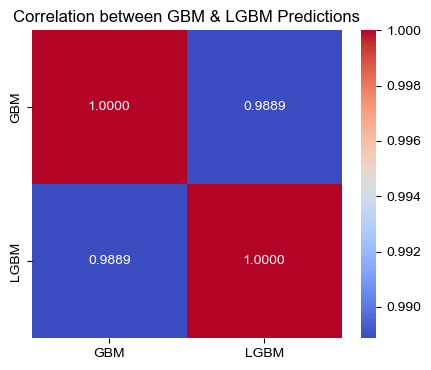

In [ ]:
gbm_test_preds = best_gbm.predict(X_test)
lgbm_test_preds = best_lgbm_model.predict(X_test)

# 데이터프레임 변환
ensemble_results = pd.DataFrame({
    "GBM": gbm_test_preds,
    "LGBM": lgbm_test_preds})

# 상관계수 행렬
corr_matrix = ensemble_results.corr()

# 히트맵 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Correlation between GBM & LGBM Predictions")
plt.show()

In [ ]:
# 단순 평균 앙상블
ensemble_preds_avg = (gbm_test_preds + lgbm_test_preds) / 2
evaluate_regression(y_test, ensemble_preds_avg, "Ensemble (Mean)")

# 가중 평균 앙상블 예측
gbm_weight = 0.6
lgbm_weight = 0.4
ensemble_preds_weighted = (gbm_weight * gbm_test_preds) + (lgbm_weight * lgbm_test_preds)

evaluate_regression(y_test, ensemble_preds_weighted, "Ensemble (Weighted Mean)")

Ensemble (Mean) 성능 평가:
 - RMSE (평균 제곱근 오차): 32189.6118
 - R² Score (결정계수): 0.7866
 - MAE (평균 절대 오차): 17217.1745

Ensemble (Weighted Mean) 성능 평가:
 - RMSE (평균 제곱근 오차): 32196.1859
 - R² Score (결정계수): 0.7865
 - MAE (평균 절대 오차): 17095.0806



In [ ]:
# 개별 모델 성능 출력
evaluate_regression(y_test, gbm_test_preds, "GradientBoosting")
evaluate_regression(y_test, lgbm_test_preds, "LGBM")

# 앙상블 성능 출력
evaluate_regression(y_test, ensemble_preds_avg, "Ensemble (Mean)")
evaluate_regression(y_test, ensemble_preds_weighted, "Ensemble (Weighted Mean)")

GradientBoosting 성능 평가:
 - RMSE (평균 제곱근 오차): 32608.4023
 - R² Score (결정계수): 0.7810
 - MAE (평균 절대 오차): 16725.1999

LGBM 성능 평가:
 - RMSE (평균 제곱근 오차): 32735.0770
 - R² Score (결정계수): 0.7793
 - MAE (평균 절대 오차): 18088.0413

Ensemble (Mean) 성능 평가:
 - RMSE (평균 제곱근 오차): 32189.6118
 - R² Score (결정계수): 0.7866
 - MAE (평균 절대 오차): 17217.1745

Ensemble (Weighted Mean) 성능 평가:
 - RMSE (평균 제곱근 오차): 32196.1859
 - R² Score (결정계수): 0.7865
 - MAE (평균 절대 오차): 17095.0806



###  4-5. SHAP 분석

- 위 결과 Ensemble (Mean) Model 성능이 모든면에서 좋다.

- 목적: 
    - 모델이 주택 가격을 예측하는 과정에서 어떤 변수를 가장 중요하게 활용했는지 분석하기 위해 SHAP 값을 계산  
    - SHAP은 개별 예측값이 도출되는 과정을 해석할 수 있도록 도와주는 기법으로, 각 Feature가 모델 예측값에 미치는 영향을 정량적으로 측정  
    - 이를 통해 리모델링 여부(`Remodel_Label`)가 주택 가격에 얼마나 영향을 미치는지, 그리고 다른 주요 Feature들이 모델 예측에서 어떤 역할을 하는지 분석  
    - 또한, Summary Plot 및 Dependence Plot을 활용하여 변수 간의 관계 및 패턴을 시각적으로 확인

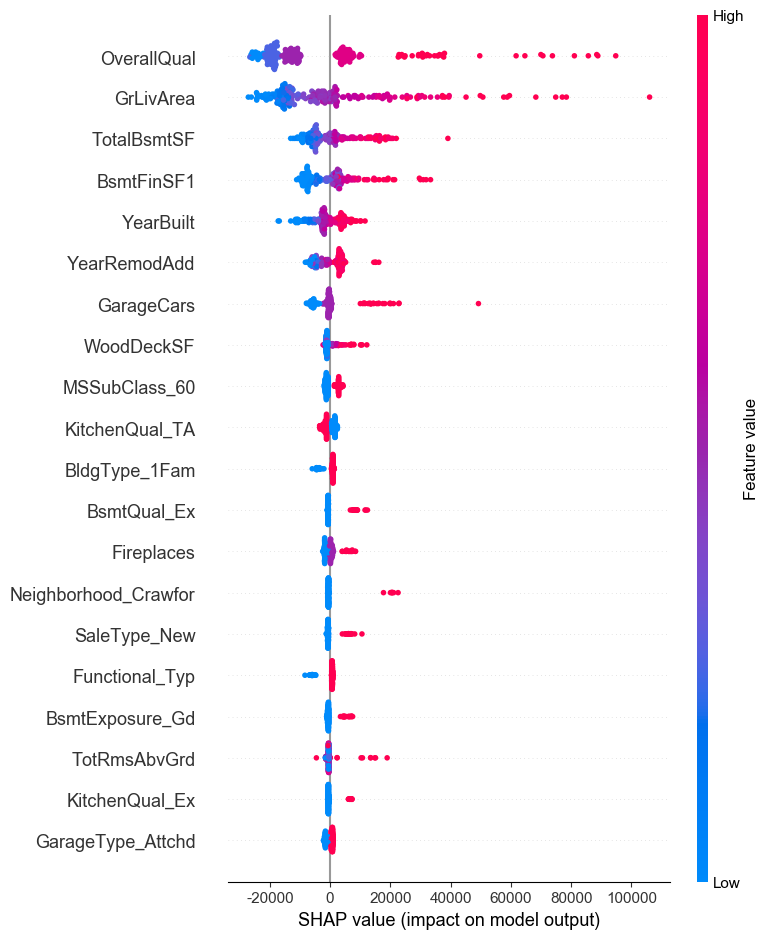

In [ ]:
# SHAP Explainer 생성
explainer_gbm = shap.Explainer(best_gbm, X_test)
explainer_lgbm = shap.Explainer(best_lgbm_model, X_test)

# SHAP 값 계산
shap_values_gbm = explainer_gbm(X_test)
shap_values_lgbm = explainer_lgbm(X_test)

# 가중 평균 앙상블 SHAP 값 계산 (단순 평균)
shap_values_ensemble_mean = (shap_values_gbm.values + shap_values_lgbm.values) / 2

# SHAP Summary Plot (단순 평균 앙상블 모델)
shap.summary_plot(shap_values_ensemble_mean, X_test)

- 전체 변수 중 주택 가격 예측에 미친 영향

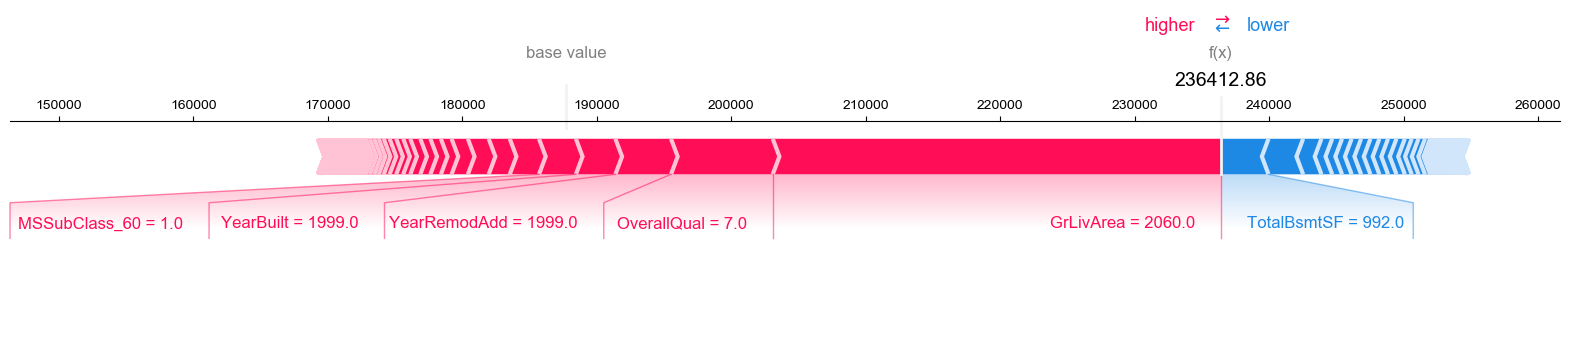

In [ ]:
# 단순 평균 앙상블의 expected_value 계산
expected_value_ensemble_mean = (explainer_gbm.expected_value + explainer_lgbm.expected_value) / 2

shap.initjs()
shap.force_plot(expected_value_ensemble_mean, 
                shap_values_ensemble_mean[0, :], 
                X_test.iloc[0, :], 
                matplotlib=True)

- 주택 품질이 가격 예측에 미치는 영향 분석

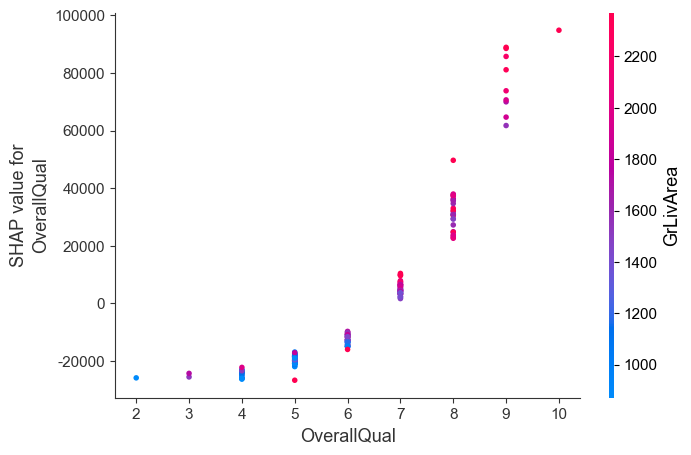

In [ ]:
# 주택 품질이 가격 예측에 미치는 영향 분석
shap.dependence_plot("OverallQual", shap_values_ensemble_mean, X_test)

- 지상 면적(1층, 2층)이 가격 예측에 미치는 영향 분석

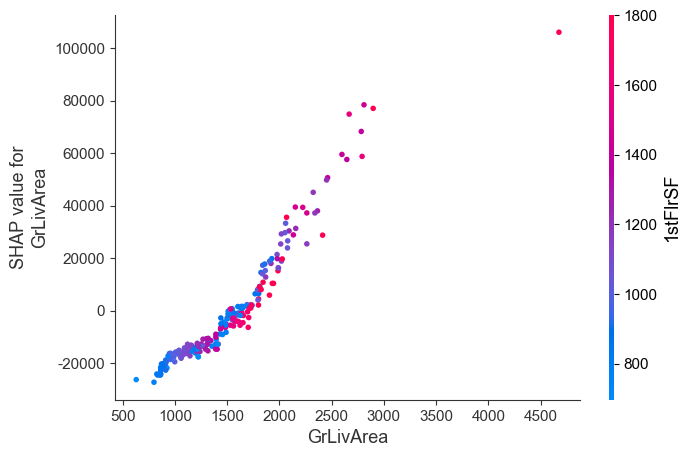

In [ ]:
# 지상 면적이 가격 예측에 미치는 영향 분석
shap.dependence_plot("GrLivArea", shap_values_ensemble_mean, X_test)

- 지하실 면적이 가격 예측에 미치는 영향 분석

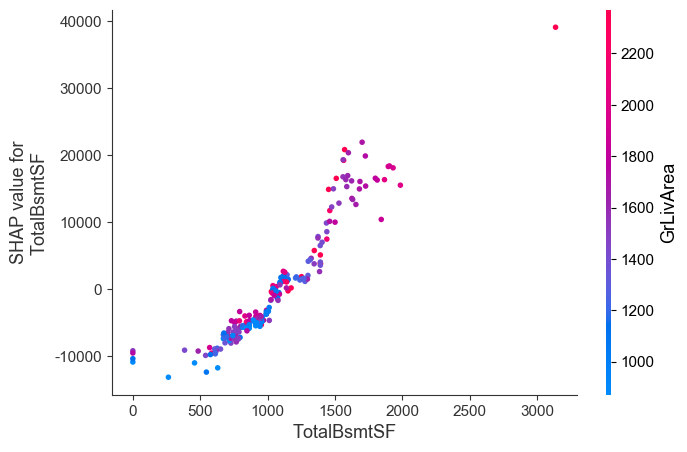

In [ ]:
shap.dependence_plot("TotalBsmtSF", shap_values_ensemble_mean, X_test)

- 리모델링연도가 가격 예측에 미치는 영향 분석

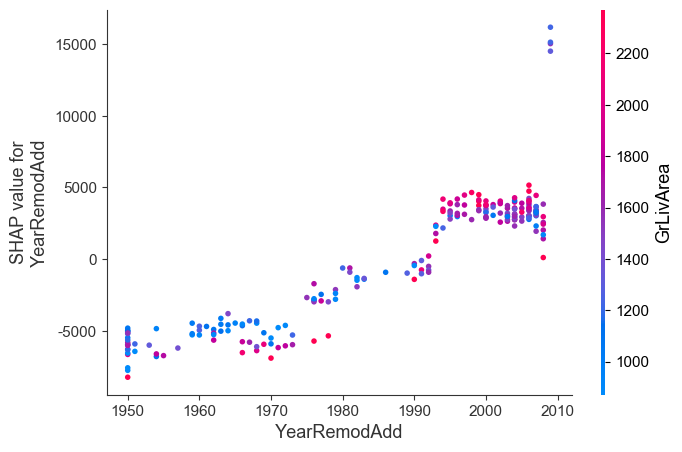

In [ ]:
# 특정 변수(YearRemodAdd)가 가격 예측에 미치는 영향 분석
shap.dependence_plot("YearRemodAdd", shap_values_ensemble_mean, X_test)

- 리모델링 여부가 가격 예측에 미치는 영향 분석

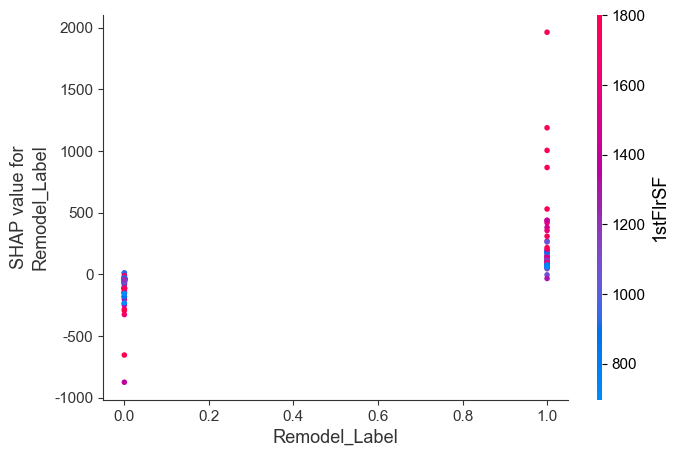

In [ ]:
shap.dependence_plot("Remodel_Label", shap_values_ensemble_mean, X_test)

- 건축 연도가 가격 예측에 미치는 영향 분석

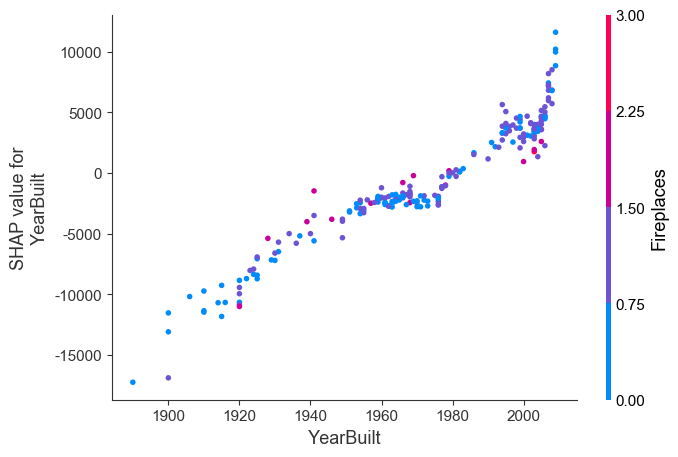

In [ ]:
shap.dependence_plot("YearBuilt", shap_values_ensemble_mean, X_test)

- 벽난로 개수가 가격 예측에 미치는 영향 분석

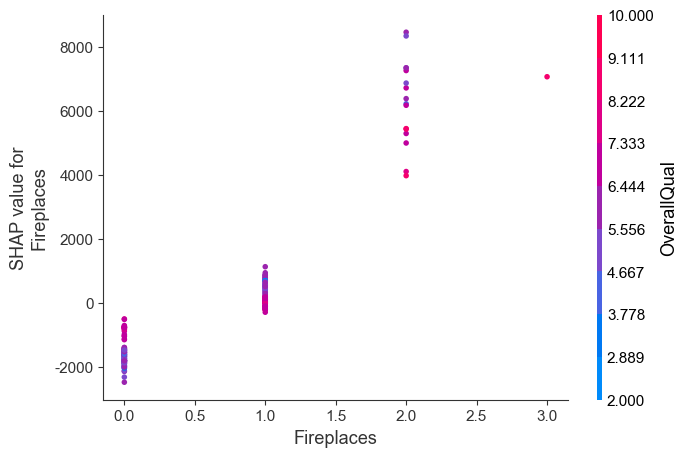

In [ ]:
shap.dependence_plot("Fireplaces", shap_values_ensemble_mean, X_test)

- 지상층 방의 개수가 가격 예측에 미치는 영향 분석

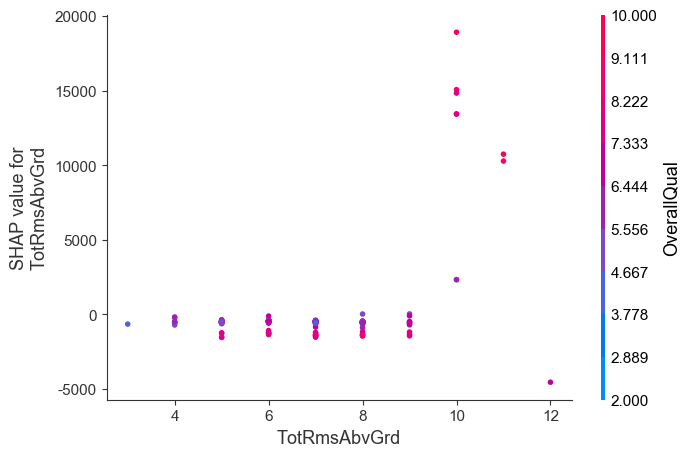

In [ ]:
shap.dependence_plot("TotRmsAbvGrd", shap_values_ensemble_mean, X_test)

In [ ]:
# 개별 모델 저장
joblib.dump(best_gbm, "gradient_boosting_model.pkl")
joblib.dump(best_lgbm_model, "lgbm_model.pkl")

['lgbm_model.pkl']

### 결과

1. 4개의 모델 후보 중 `GradientBoosting`, `LGBM` 이 성능이 우수하여 선정

2. 선정된 모델 성능을 비교한 결과 `GradientBoosting` 모델의 성능이 가장 우수

3. 두 모델을 앙상블한 결과 단순 평균 기반으로한 앙상블 모델이 모든 지표에서 가장 우수한 지표를 나타냄

4. SHAP 분석 결과 주택 품질, 지상 면적, 지하실 면적, 리모델링 연도, 건축 연도, 등이 `SalePrice`의 영향을 미치는 변수임을 나타냄

### 결론
- 리모델링이 주택 가격 상승에 기여하는 것은 맞지만, 그 기여도가 크다고 단정짓기는 어렵다.
- 리모델링 효과는 특정 조건에서 더 뚜렷하게 나타남
- 리모델링을 고려할 때 추가적인 요인을 함께 분석해야 함(거주 지역, 주택 품질)
- 단순히 리모델링을 했다고 가격이 오르는 것이 아니라, 주택의 위치와 기존 상태에 따라 리모델링의 효과가 달라질 수 있다.


----------------------------------------------

## 5.&nbsp; OLS 회귀 분석

- 설명: 리모델링 그룹과 전체 데이터로 개별 분석

- 목적:
    - 해석 가능성 강화: OLS 회귀는 변수별 직접적인 계수 해석이 가능하여, 리모델링과 주택 가격 간 관계를 보다 명확하게 설명
    - 통계적 유의성 검토: 각 변수의 P-value를 통해 리모델링과 주요 변수들이 주택 가격에 미치는 영향이 통계적으로 유의한지 검증
    - 리모델링 효과 검증: 리모델링 후 경과 연수(Elapsed_Years)가 주택 가격에 미치는 영향을 분석하여, 머신러닝 기반 모델 결과와 비교 및 보완 가능.

In [44]:
# VIF 다중공선성 확인
def VIF(df):
    vif_data = df.copy()
    vif_with_constant = add_constant(vif_data)

    vif = pd.DataFrame()
    vif['features'] = vif_with_constant.columns
    vif['VIF'] = [round(variance_inflation_factor(vif_with_constant.values, i), 4)
                    for i in range(vif_with_constant.shape[1])]

    vif = vif.sort_values('VIF', ascending=False).reset_index(drop=True)
    vif = vif[vif['features'] != 'const']
    return vif

# OLS 회귀 분석
def OLS(df, target_column='SalePrice'):    
    # 분리
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # 상수항 추가
    X = sm.add_constant(X)

    # OLS 회귀 모델 학습
    model = sm.OLS(y, X).fit()
    
    # 데이터프레임 생성
    results_df = pd.DataFrame({
        "coef": model.params,
        "std err": model.bse,
        "t": model.tvalues,
        "P>|t|": model.pvalues,
        "[0.025": model.conf_int()[0],
        "0.975]": model.conf_int()[1]})
    
    print(model.summary())    
    return results_df

In [ ]:
# get_dummies (drop_first=True 설정하여 기준 그룹 제거)
ols_df = pd.get_dummies(df, drop_first=True).astype(int).copy()
ols_table = OLS(ols_df, 'SalePrice')

vif = VIF(ols_df)
inf = vif[np.isinf(vif['VIF']) | (vif['VIF'] >= 10)]
not_inf = vif[~np.isinf(vif['VIF']) & (vif['VIF'] <= 9.99)]

print(f"Inf length: {len(inf)}")
print(f"Not Inf: {len(not_inf)}")

inf

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     47.27
Date:                Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:55:08   Log-Likelihood:                -16909.
No. Observations:                1460   AIC:                         3.426e+04
Df Residuals:                    1239   BIC:                         3.543e+04
Df Model:                         220                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

divide by zero encountered in scalar divide


Inf length: 89
Not Inf: 139


,features,VIF
0,GarageQual_No_GarageQual,inf
1,BldgType_Duplex,inf
2,BsmtFinType1_No_BsmtFinType1,inf
3,Exterior1st_CBlock,inf
4,Exterior2nd_CBlock,inf
...,...,...
85,KitchenQual_TA,10.9542
86,Exterior2nd_Wd Shng,10.9076
87,Heating_Grav,10.7369
88,MSSubClass_160,10.2973


In [ ]:
# OLS 결과 확인
ols_p = ols_table[ols_table['P>|t|'] < 0.05]
ols_notp = ols_table.loc[~ols_table.index.isin(ols_p.index)] # 유의미하지 않은 변수

print(f"유의미하지 않은 컬럼 개수: {len(ols_notp)}")
print(f"유의미한 컬럼 개수: {len(ols_p)}")

ols_p 

유의미하지 않은 컬럼 개수: 180
유의미한 컬럼 개수: 48


,coef,std err,t,P>|t|,[0.025,0.975]
OverallQual,8544.698752,1240.581193,6.887658,8.997654e-12,6110.826713,10978.570791
GrLivArea,65.899546,6.440425,10.232173,1.203287e-23,53.264201,78.534891
GarageCars,11318.644106,1943.580947,5.823603,7.330700e-09,7505.570563,15131.717648
1stFlrSF,-18.284411,8.734657,-2.093318,3.652373e-02,-35.420763,-1.148058
WoodDeckSF,23.285743,7.047201,3.304254,9.795183e-04,9.459976,37.111509
Remodel_Label,4287.449084,2122.199289,2.020286,4.356859e-02,123.947702,8450.950466
Neighborhood_Edwards,-21014.343867,9818.278104,-2.140329,3.252298e-02,-40276.632130,-1752.055605
Neighborhood_NoRidge,45409.996088,10317.056035,4.401449,1.167851e-05,25169.165133,65650.827044
Neighborhood_NridgHt,32056.211140,9126.235223,3.512534,4.598249e-04,14151.628303,49960.793977
Neighborhood_StoneBr,51507.448926,10247.986334,5.026104,5.740256e-07,31402.124470,71612.773382


- VIF 값이 높고 p-value > 0.05 변수 제외 후 다시 OLS 분석

In [ ]:
high_vif = vif[vif['VIF'] >= 10]['features'].values
ols_df = ols_df.drop(columns=high_vif, errors='ignore')

ols_table = OLS(ols_df, 'SalePrice')
ols_p = ols_table[ols_table['P>|t|'] < 0.05]  # 유의미한 변수만 남김  
ols_notp = ols_table.loc[~ols_table.index.isin(ols_p.index)] # 유의미하지 않은 변수

print(f"최종 유의미한 변수 개수: {len(ols_p)}")
print(f"최종 유의미하지 않는 변수 개수: {len(ols_notp)}")
ols_p

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     51.25
Date:                Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:55:44   Log-Likelihood:                -17194.
No. Observations:                1460   AIC:                         3.467e+04
Df Residuals:                    1321   BIC:                         3.540e+04
Df Model:                         138                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,coef,std err,t,P>|t|,[0.025,0.975]
OverallQual,18466.336728,1212.081292,15.235230,2.085200e-48,16088.522413,20844.151042
GarageCars,15291.753759,1762.790291,8.674744,1.196557e-17,11833.579778,18749.927739
TotRmsAbvGrd,10334.566544,718.408563,14.385361,1.066174e-43,8925.220342,11743.912745
YearRemodAdd,345.024226,71.380214,4.833612,1.497776e-06,204.993275,485.055176
MasVnrArea,18.949849,6.194562,3.059111,2.264633e-03,6.797597,31.102101
Fireplaces,9111.986181,1816.730016,5.015597,6.006160e-07,5547.995329,12675.977033
BsmtFinSF1,16.286539,3.215891,5.064393,4.676913e-07,9.977727,22.595350
WoodDeckSF,30.653723,8.000874,3.831297,1.334545e-04,14.957917,46.349529
Remodel_Label,4573.190547,2259.183407,2.024267,4.314359e-02,141.211703,9005.169392
Neighborhood_BrDale,-31624.415182,9074.441832,-3.484998,5.082499e-04,-49426.305056,-13822.525307


- 리모델링 그룹으로 별도 분석

In [45]:
# 리모델링 그룹
ols_Remodel = df_Remodel.drop(columns=['Elapsed_Group', 'YearRemodAdd', 'Remodel_Label'])
ols_Remodel = pd.get_dummies(ols_Remodel, drop_first=True).astype(int).copy()
Remodl_ols = OLS(ols_Remodel, 'SalePrice')

vif = VIF(ols_Remodel)
inf = vif[np.isinf(vif['VIF']) | (vif['VIF'] >= 10)]
not_inf = vif[~np.isinf(vif['VIF']) & (vif['VIF'] <= 9.99)]

print(f"Inf length: {len(inf)}")
print(f"Not Inf: {len(not_inf)}")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     27.30
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          1.62e-182
Time:                        21:13:25   Log-Likelihood:                -8028.5
No. Observations:                 696   AIC:                         1.648e+04
Df Residuals:                     486   BIC:                         1.743e+04
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

divide by zero encountered in scalar divide


Inf length: 96
Not Inf: 124


In [46]:
# 마찬가지로 다중공선성 제거하고 재 확인
high_vif = vif[vif['VIF'] >= 10]['features'].values

# 타겟변수 삭제 방지
if 'SalePrice' in high_vif:
    high_vif = [col for col in high_vif if col != 'SalePrice']

ols_Remodel = ols_Remodel.drop(columns=high_vif, errors='ignore')
Remodl_ols = OLS(ols_Remodel, 'SalePrice')
ols_p = Remodl_ols[Remodl_ols['P>|t|'] < 0.05]  # 유의미한 변수만 남김  
ols_notp = Remodl_ols.loc[~Remodl_ols.index.isin(ols_p.index)] # 유의미하지 않은 변수

print(f"최종 유의미한 변수 개수: {len(ols_p)}")
print(f"최종 유의미하지 않는 변수 개수: {len(ols_notp)}")
ols_p

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     29.69
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          1.01e-184
Time:                        21:13:46   Log-Likelihood:                -8215.4
No. Observations:                 696   AIC:                         1.668e+04
Df Residuals:                     571   BIC:                         1.725e+04
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,coef,std err,t,P>|t|,[0.025,0.975]
OverallQual,17731.717501,1840.621850,9.633547,1.875506e-20,14116.501975,21346.933026
GarageCars,12754.865999,2692.404152,4.737352,2.735774e-06,7466.641648,18043.090350
TotRmsAbvGrd,11453.556169,1146.253779,9.992164,8.956343e-22,9202.167891,13704.944447
MasVnrArea,38.286051,10.647026,3.595938,3.512146e-04,17.373937,59.198166
Fireplaces,14794.674408,2851.712627,5.187996,2.957485e-07,9193.547941,20395.800875
BsmtFinSF1,26.283921,5.955423,4.413443,1.216701e-05,14.586712,37.981130
WoodDeckSF,27.464789,13.286039,2.067192,3.916616e-02,1.369317,53.560261
Elapsed_Years,-361.301622,93.646274,-3.858153,1.272698e-04,-545.234821,-177.368424
Neighborhood_NoRidge,73162.128527,10938.519684,6.688485,5.384085e-11,51677.483988,94646.773066
Neighborhood_NridgHt,29982.595525,7966.350273,3.763655,1.847626e-04,14335.669905,45629.521145


----------------------

## 최종 결과

1. 리모델링 효과 분석: 리모델링 그룹과 비리모델링 그룹 간 판매 가격 비교 결과, 통계적으로 유의미한 차이가 존재함을 확인 (p-value = 0.0011)

2. 시계열 분석 결과: 시계열 간 가격 변동성이 존재하며, 일정한 패턴을 가지지 않음, 리모델링 후 약 30년이 지나면 가격이 급격히 하락하는 경향이 보임

3. 모델링 결과: 다양한 회귀 모델을 비교한 결과, GradientBoosting 모델이 가장 성능이 우수

4. SHAP 분석 결과: 리모델링 효과는 단독으로 가격을 결정하는 것이 아니라, 기존 주택의 품질과 함께 고려해야 함

5. 최종 OLS 분석 결과:
    
    - Remodel_Label(리모델링 여부)와 YearRemodAdd(리모델링 연도)는 유의미한 변수로 확인됨
    - 이는 리모델링이 주택 가격 상승에 일정 부분 기여하는 요소임을 시사
    - 그러나 Elapsed_Years(리모델링 후 경과 연수)가 증가할수록 가격이 하락하는 경향도 있음
    - 리모델링 효과는 단기적으로(0년~3년) 존재하나, 시간이 지날수록 그 효과가 감소하는 것으로 해석됨


## 결론

- 리모델링은 주택 가격 상승에 기여하며, 통계적으로도 유의미한 영향을 미친다, 특히 리모델링 연도가 최근일수록 가격 상승 효과가 더욱 뚜렷하게 나타난다.
- 리모델링 효과는 단독으로 가격을 결정하는 것이 아니라, 주택의 품질, 크기와 함께 고려해야한다.
- 주택 품질(OverallQual)과 면적(GrLivArea, TotalBsmtSF)이 가격에 가장 큰 영향을 미친다.
- 리모델링을 통해 가격 상승 효과를 극대화하려면, 고품질 주택에서 리모델링을 실행하는 것이 더 효과적이다.(고가 지역)

----------

## 회고

- 이번 프로젝트를 통해 리모델링이 주택 가격에 미치는 영향을 다각도로 분석하면서, 전반적인 EDA 과정과 논리적인 흐름으로 분석을 할 수 있었다.
- 특히, 단순한 리모델링 여부보다 연도와 주택 품질이 중요한 영향을 미친다는 점을 데이터 기반으로 검증할 수 있었던 점이 의미 있었다. 
- 다만, 데이터 row수가 1064개로 제한적이였고, 리모델링 전,후의 개별 주택 데이터를 비교할 수 없다는 점이 가장 큰 아쉬움이다.